# **Advanced Statistics for Physics Analysis Final Project**: Distribution of a Population of Gravitational Wave Sources

We consider a population of GW sources and let $n$ be the numerical density of the popoulation, i.e. the number of sources observed in a fixed time interval per unity volume. We assume that $n$ is a low density, so that even for large volumes the number of sources is small enough. Moreover, we have that the average number of observations per unity volume in a fixed time interval $T$ is $nT$.

We also neglect cosmological effects (we work with redshift $z \ll 1$). Finally, we assume that the positions of the sources are statistically independent. 

In [1]:
# libraries

library(coda)
library(ggplot2)
library(gridExtra)
library(rjags)
library(ggpubr)
library(patchwork)

# plot colours

color_palette <- c( "#003f5c",
                    "#58508d",
                    "#bc5090",
                    "#ff6361",
                    "#ffa600"
                    )


# plot settings

std_width  <- 12
std_height <- 8
options(repr.plot.width = std_width, repr.plot.height = std_height)

scientific_10 <- function(x) {
  parse(text=gsub("e", " %*% 10^", scales::scientific_format()(x)))
}

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



ERROR: Error in library(ggpubr): non c'`e alcun pacchetto chiamato 'ggpubr'


### 1. Statistical model of the population

*Given a spherical shell of radius $R$ and thickness $\Delta R$ centered in the Sun, what probability distribution should the number of sources in the shell have?*
*Given the probability distribution of the previous question, what is the average number of sources in the shell and what is the corresponding variance?*

The volume of the spherical shell is equal to $V = 4 \pi R^2 \Delta R$, so the average number of sources in the time interval $T$ results in $\langle N \rangle = nTV = nT 4 \pi R^2 \Delta R$. Moreover, since we assumed that the sources positions are statistically independent, the distribution of the number of sources $N$ in the spherical shell we considered follows a Poisson distribution. The rate of this Poisson distribution is $\lambda = nT4 \pi R^2 \Delta R$ since the expectation value $ \text{E}[N] = \langle N \rangle$ is equal to the rate parameter for the Poisson distribution. Finally, also the variance $\text{Var}(N)$ is equal to $\lambda$, so we have $\text{Var}(N) = nT 4 \pi R^2 \Delta R $.

In [ ]:
# spherical shell radius (Mpc)
R <- 440  
# spherical shell thickness (in the order of kpc)
DeltaR <- R * 10^(-3) 
# population numerical density (Mpc^-3 s^-1)
n <- 3e-12 
# observation time (s, about 1 year )
T <- 3e7 

# rate parameter of the Poisson distribution
lambda_pois <- n * T * 4 * pi * R^2 * DeltaR

# number of sources
N <- seq(floor(lambda_pois - 5 * sqrt(lambda_pois)), floor(lambda_pois + 5 * sqrt(lambda_pois)))

# Poisson distribution
distrib_sources <- dpois(N, lambda_pois)

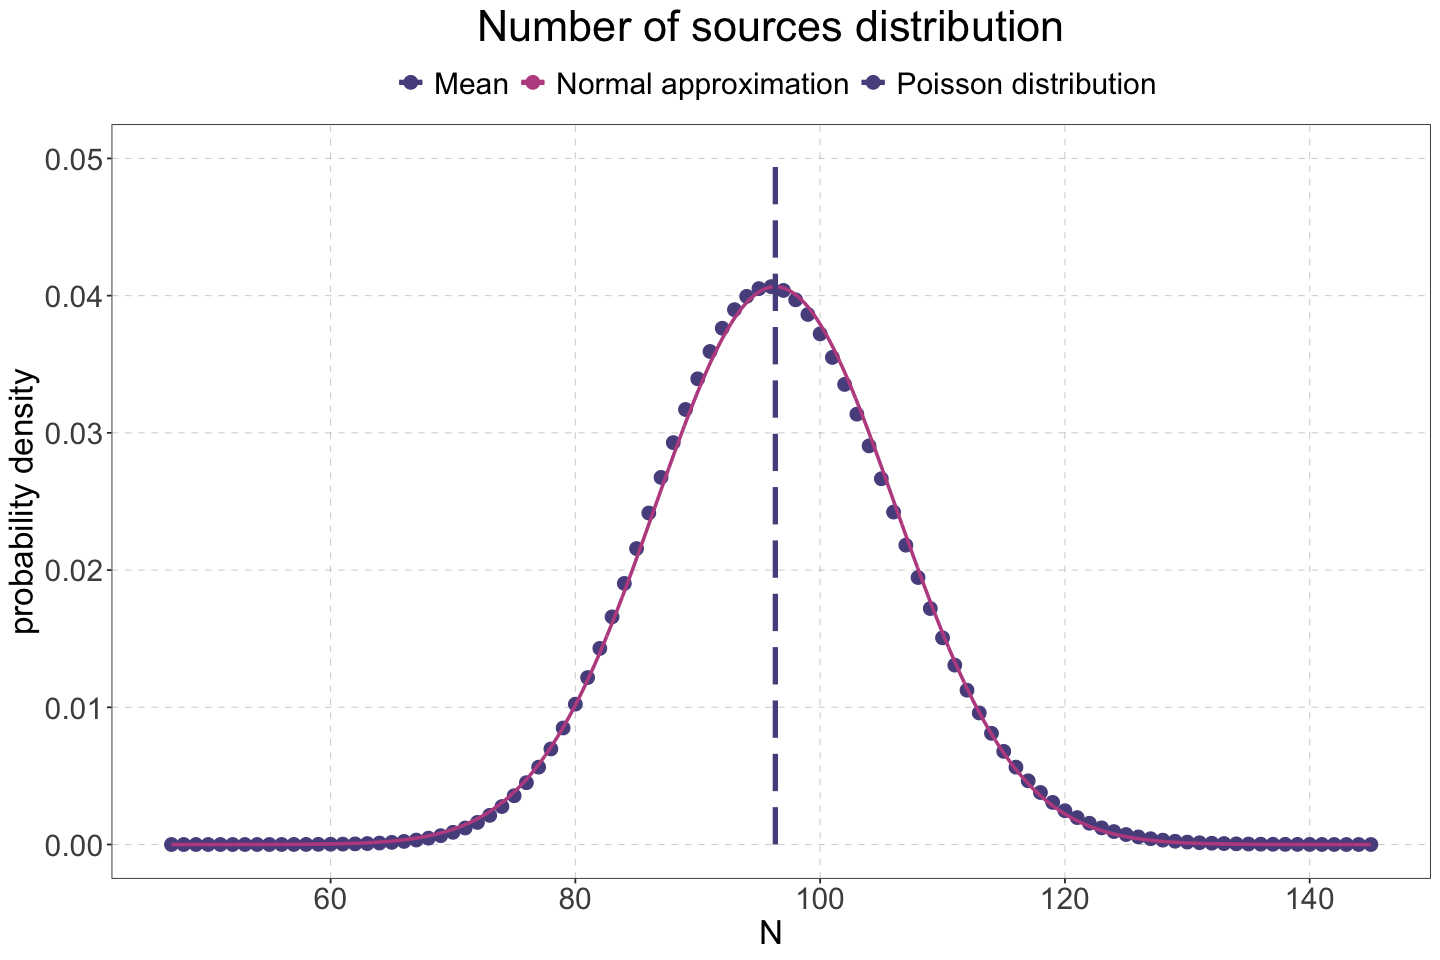

In [ ]:
# plot

N_norm <- seq(floor(lambda_pois - 5 * sqrt(lambda_pois)), floor(lambda_pois + 5 * sqrt(lambda_pois)), 0.01)

plotN <- ggplot() + 
        geom_point(
            aes(
                x = N,
                y = distrib_sources,
                color = "Poisson distribution"
            ),
            size = 3.5
        ) +
        geom_line(
            aes(
                x = N_norm,
                y = dnorm(N_norm, mean = lambda_pois, sd = sqrt(lambda_pois)),
                color = "Normal approximation"
            ),
            linewidth = 1
        ) +
        geom_segment(
            aes(
                x = lambda_pois,
                y = 0,
                xend = lambda_pois,
                yend = 0.05,
                color = "Mean"
            ),
            linewidth = 1.5,
            linetype = 'longdash'
        ) +
        theme_bw() +
        theme( 
            plot.title = element_text(size = 26, hjust = 0.5),
            axis.title = element_text(size = 20),
            axis.text  = element_text(size = 18),
            legend.position = "top",
            legend.text  = element_text(size = 18),
            panel.grid.major.y = element_line( 
                                       color = alpha("black",0.2),
                                       linewidth = 0.3,
                                       linetype = 2 
                                       ),
            panel.grid.major.x = element_line( 
                                       color = alpha("black",0.2),
                                       linewidth = 0.3,
                                       linetype = 2 
                                       ),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            legend.background = element_rect( 
                                       fill = "white",
                                       linewidth = 0.5, 
                                       linetype = "solid", 
                                       colour = "white" 
                                       ) 
        ) +
        labs( 
            x = expression(N), 
            y = "probability density", 
            title = "Number of sources distribution" 
            ) +
        scale_color_manual(
            name = "",
            values = c(
                "Poisson distribution" = color_palette[2], 
                "Mean" = color_palette[2],
                "Normal approximation" = color_palette[3]
                )
        ) + 
        scale_x_continuous(n.breaks = 8)

plotN

*Based on the previous answers, what is our ability to observe an excess or a reduction in the number of sources at a given distance?*

We know that the number of souces we observe is equal to $N_{obs} = N \epsilon(h)$, where $\epsilon(h)$ is the detection efficiency, a function of the strain amplitude $h$.
Then, we can interpret the ability to observe an excess or a reduction in the number of sources at a given distance respectively as the probability to observe a number of sources outside the interval $[\mu + \sigma, \mu - \sigma]$, where $\mu$ and $\sigma^2$ are respectively the mean and the variance of the distribution for $N_{obs}$. 

### 2. Analysis of the detection efficiency

As the distance from the Sun increases, the detection efficiency of the number of sources is decreasing; suppose we characterize the amplitude of gravitational radiation by the maximum strain $h$ and suppose also that we can neglect the distinction between polarizations and the orientation of the sources. In this case $h \propto \frac{1}{r}$ (with $r$ as the distance from the source). Finally we assume that the detection efficiency can be described with a sigmoid function that we can approximate with the following Gaussian integral:

$$ \epsilon (h) = \int_{-\infty}^h \frac{1}{\sqrt{2\pi w^2}}\exp\left[ - \frac{(h'-h_0)^2}{2w^2} \right]dh'$$

where $h_0$ is the strain produced by a source positioned ad distance $r_0$ that corresponds to an efficiency detection of $0.5$.

We recall that the efficiency is the probability of observing a source, so this expression tells us that if $h$ is large, the efficiency is very close to $1$ (its maximum). On the contrary, if $h$ is small, the efficiency is extremely low, almost $0$. This efficiency model depends on two parameters, $h_0$ and $w$: the last one adjusts the slope of the sigmoid around $h_0$, i.e. if $w$ is small, the derivative of the efficiency computed in $h_0$ is large.

We can express the efficiency as a function of the distance from the source $r$:
$$ \hat{\epsilon}(r) = \epsilon(r(h)) = \epsilon\big(\frac{1}{h}\big) $$


In [ ]:
# parameters 
h0 <- 120 # x 1e-23 
w <- 25

# strain values (x 1e-23 ) 
h <- 10^seq(1, 3, 0.001)

# efficiency curve in function of h
efficiency <- pnorm(h, mean = h0, sd = w)

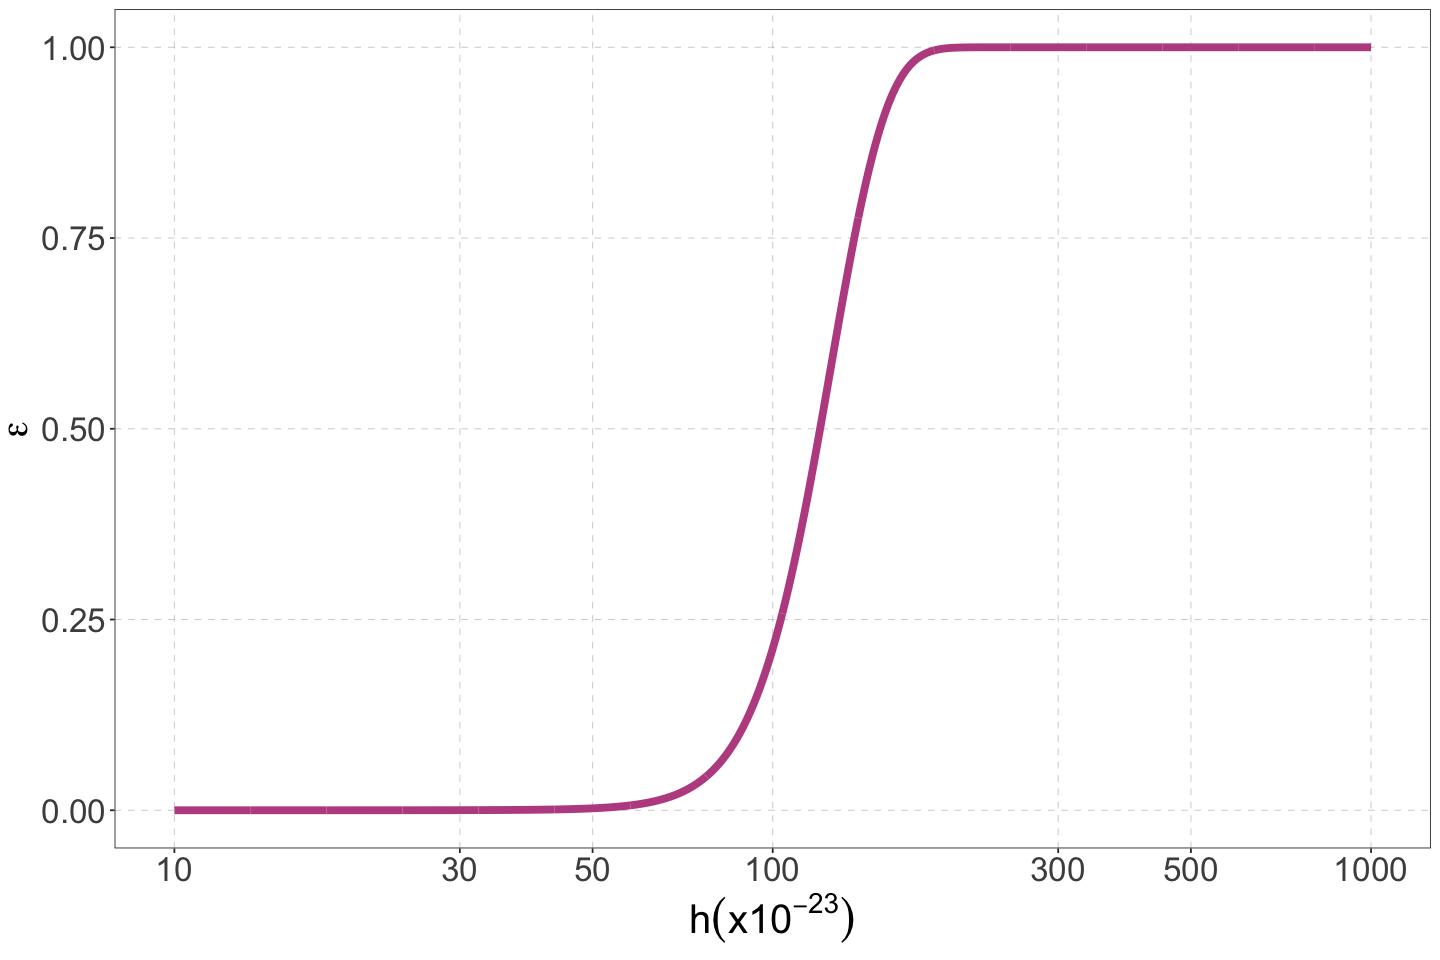

In [ ]:
plotepsilon <- ggplot() +
                geom_line(
                    aes(
                        x = h,
                        y = efficiency
                    ),
                    color = color_palette[3],
                    linewidth = 2.2
                ) +
                scale_x_continuous(trans='log10', n.breaks = 8) +
                theme_bw() +
                theme( 
                    plot.title = element_text(size = 26, hjust = 0.5),
                    axis.title = element_text(size = 24),
                    axis.text  = element_text(size = 20),
                    legend.position = "top",
                    legend.text  = element_text(size = 18),
                    panel.grid.major.y = element_line( 
                                            color = alpha("black",0.2),
                                            linewidth = 0.3,
                                            linetype = 2 
                                            ),
                    panel.grid.major.x = element_line( 
                                            color = alpha("black",0.2),
                                            linewidth = 0.3,
                                            linetype = 2 
                                            ),
                    panel.grid.minor = element_blank(),
                    panel.background = element_blank(),
                    legend.background = element_rect( 
                                            fill = "white",
                                            linewidth = 0.5, 
                                            linetype = "solid", 
                                            colour = "white" 
                                            ) 
                ) +
                labs( 
                    x = expression(h(x10^-23)),
                    y = expression(epsilon)
                    )

plotepsilon

In [ ]:
# efficiency as a function of r

# distances (Mpc)
r <- 1e5/h # took 1e5 as the proportionality factor so that for r = 440 Mpc \epsilon ~ 1 
r <- r[r >= 20 & r <= 1e+4] # we suppose to observe from 20 Mpc until 10 Gpc

epsilon_r <- pnorm(1e5/r, h0, w)

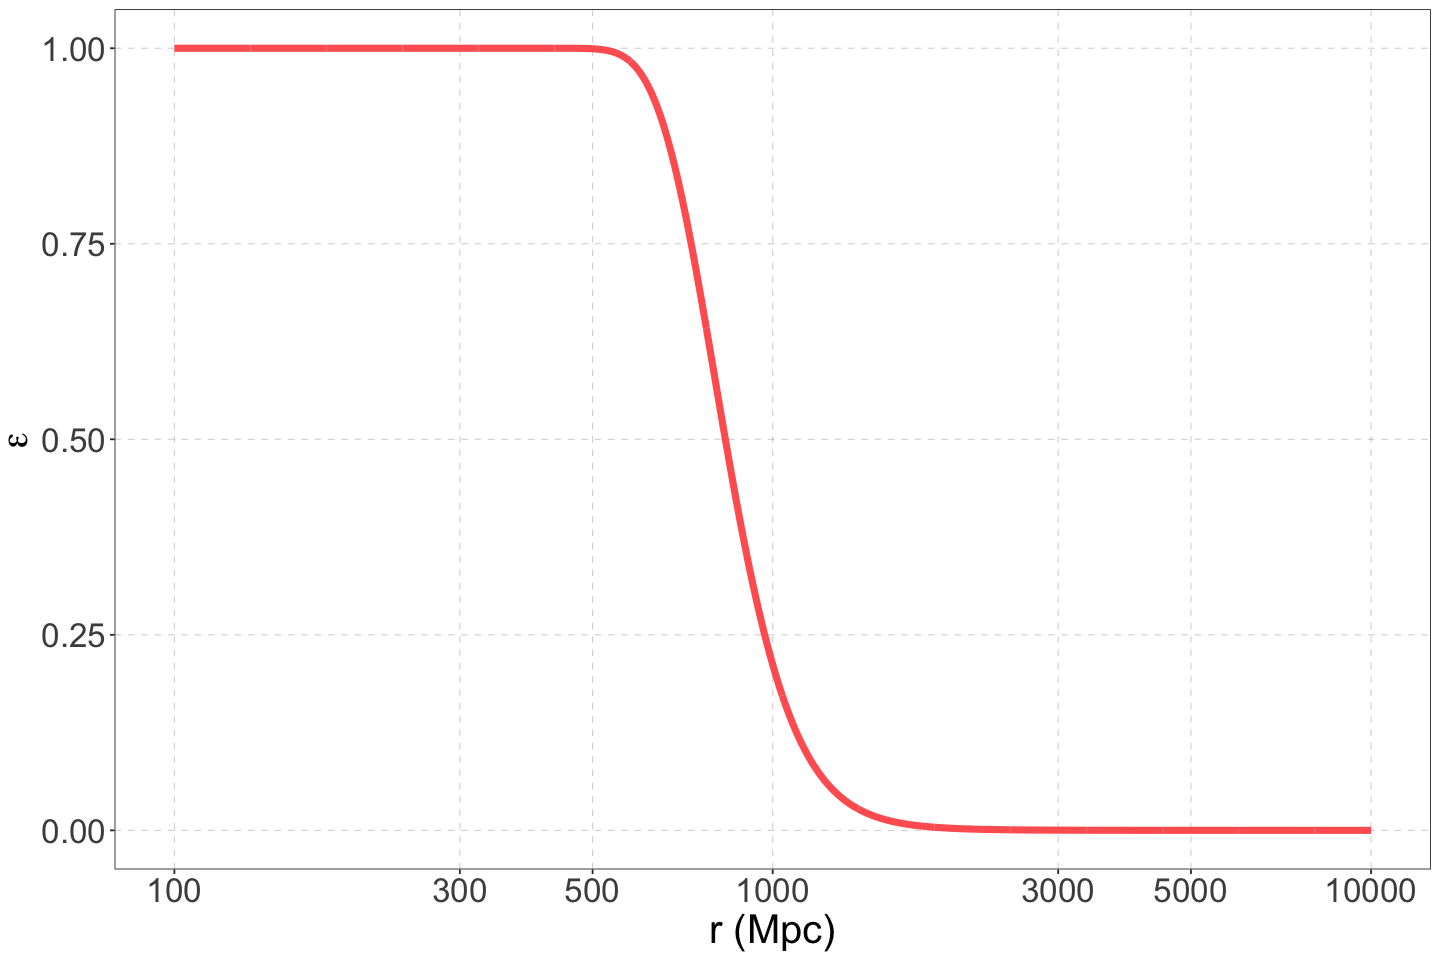

In [ ]:
plepsr <- ggplot() +
            geom_line(
                aes(
                    x = r,
                    y = epsilon_r
                ),
                color = color_palette[4],
                linewidth = 2
            ) +
            scale_x_continuous(trans='log10', n.breaks = 8) +
            theme_bw() +
            theme( 
                plot.title = element_text(size = 26, hjust = 0.5),
                axis.title = element_text(size = 24),
                axis.text  = element_text(size = 20),
                legend.position = "top",
                legend.text  = element_text(size = 18),
                panel.grid.major.y = element_line( 
                                        color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 
                                        ),
                panel.grid.major.x = element_line( 
                                        color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 
                                        ),
                panel.grid.minor = element_blank(),
                panel.background = element_blank(),
                legend.background = element_rect( 
                                        fill = "white",
                                        linewidth = 0.5, 
                                        linetype = "solid", 
                                        colour = "white" 
                                        ) 
            ) +
            labs( 
                x = "r (Mpc)",
                y = expression(epsilon)
                )

plepsr

### 3. Population density models and simulations

1. n = const
2. n = n(r) : we model $n(r)$ as a sigmoid curve to simulate the reduction in the density of sources as we "go back in time"


In [ ]:
# sigmoid to explain the number of sources as a function of distances
r0_new <- 1500
h0_new <- 1e5/r0_new
w_new <- 60
sigmoid <- pnorm(1e5/r, h0_new, w_new)

n_r <- n * sigmoid

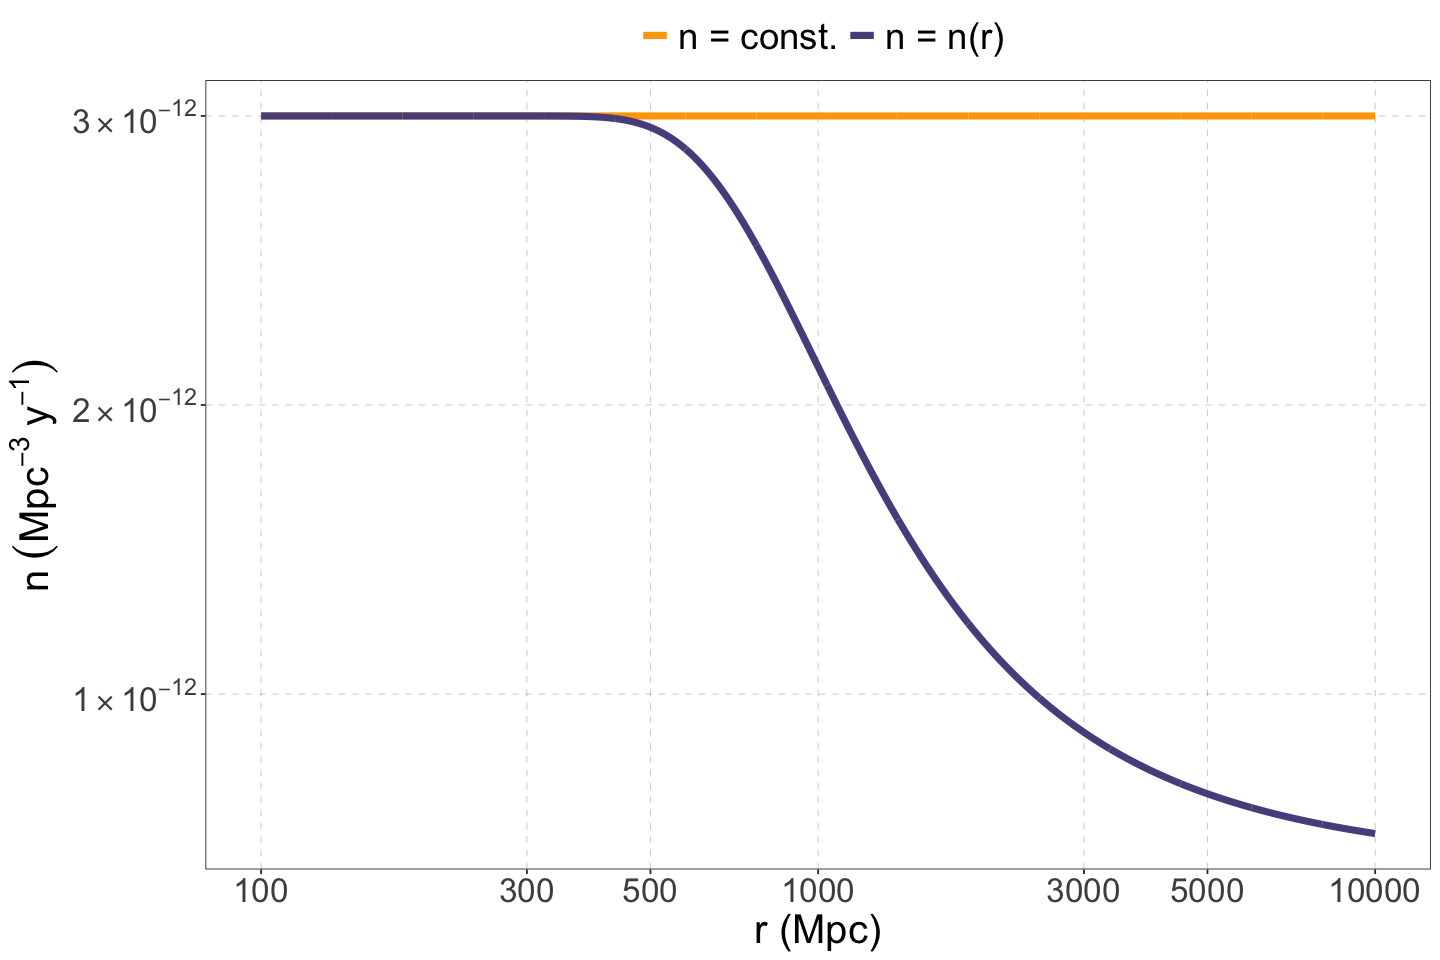

In [ ]:
plotnmod <- ggplot() +
            geom_line(
                aes(
                    x = r,
                    y = n,
                    color = "n = const."
                ),
                linewidth = 2
            ) +
            geom_line(
                aes(
                    x = r,
                    y = n_r,
                    color = "n = n(r)"
                ),
                linewidth = 2
            ) +
            scale_x_continuous(trans='log10', n.breaks = 8) +
            scale_y_continuous(label=scientific_10) +
            theme_bw() +
            theme( 
                plot.title = element_text(size = 26, hjust = 0.5),
                axis.title = element_text(size = 24),
                axis.text  = element_text(size = 20),
                legend.position = "top",
                legend.text  = element_text(size = 22),
                panel.grid.major.y = element_line( 
                                        color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 
                                        ),
                panel.grid.major.x = element_line( 
                                        color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 
                                        ),
                panel.grid.minor = element_blank(),
                panel.background = element_blank(),
                legend.background = element_rect( 
                                        fill = "white",
                                        linewidth = 0.5, 
                                        linetype = "solid", 
                                        colour = "white" 
                                        ) 
            ) +
            labs( 
                x = "r (Mpc)",
                y = expression(n~(Mpc^{-3}~y^{-1}))
                ) +
        scale_color_manual(
            name = "",
            values = c(
                "n = const." = color_palette[5], 
                "n = n(r)" = color_palette[2]
                )
        )

plotnmod

We simulate data from both models for the number of observed sources.

In [ ]:
set.seed(290623)

# number of samples used for the simulations
sample_dim <- 1e+5

# Poisson distribution rate as a function of r
# for the number of observed sources

# case of constant n
lambda_simul <- 4 * pi * r^2 * DeltaR * n * T * epsilon_r 

# case of n = n(r)
lambda_simul_r <- 4 * pi * r^2 * DeltaR * n_r * T * epsilon_r 

#  expected number of sources (without efficiency and with constant n)
lambda_exp <- 4 * pi * r^2 * DeltaR * n * T

lambda_sim <- cbind(lambda_simul, lambda_simul_r)

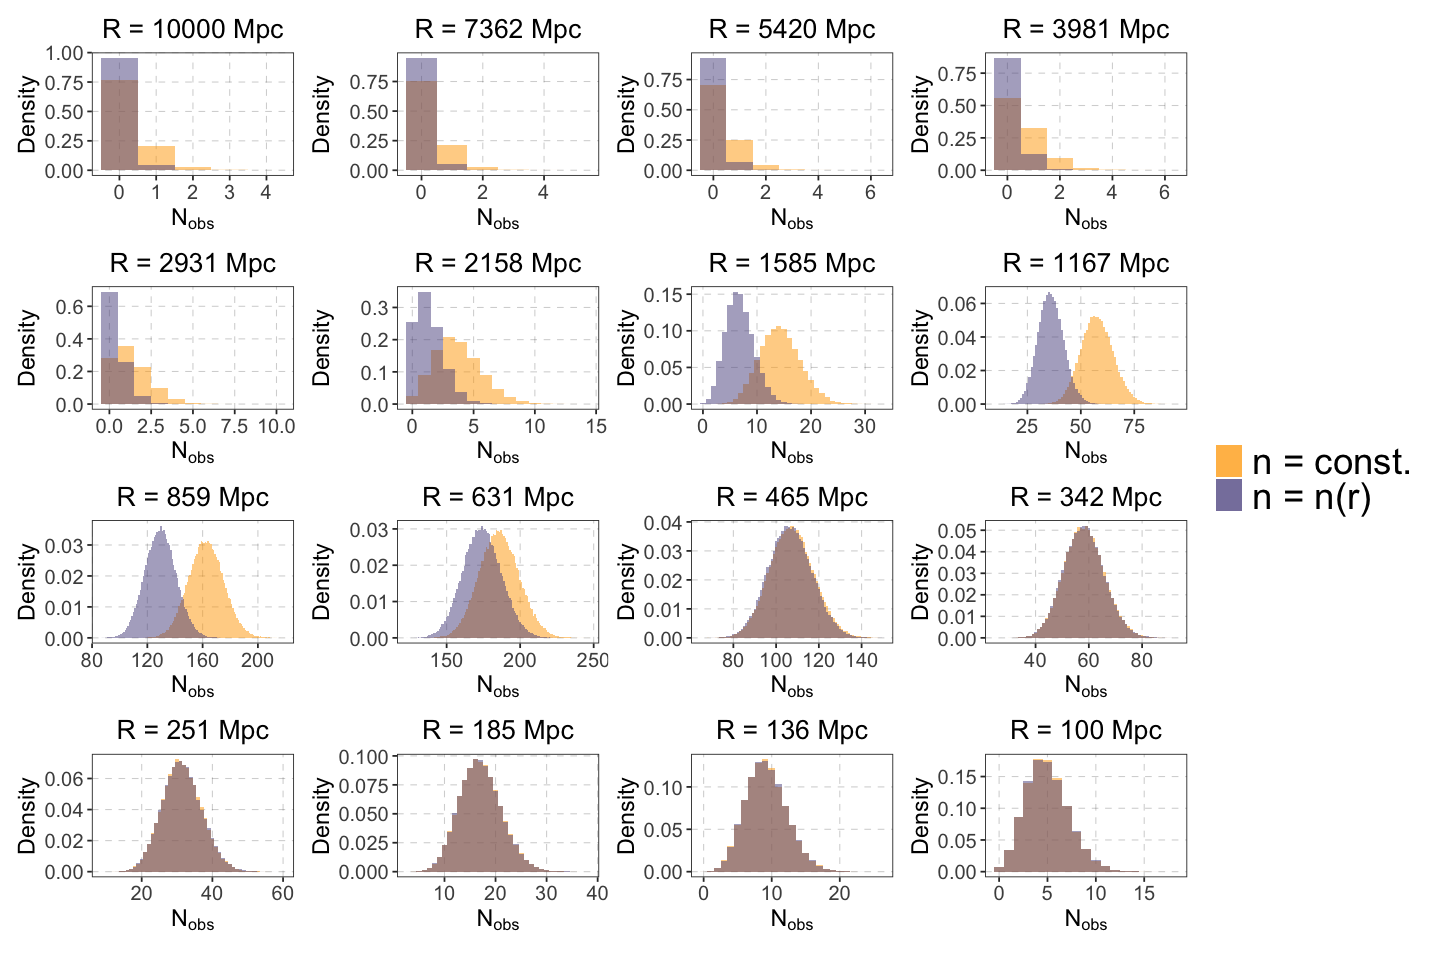

In [ ]:
plot_list <- lapply(seq(1, length(lambda_simul), length.out = 16), function(i) {
  p1 <- ggplot() +
    geom_histogram(
      aes(
        x = rpois(sample_dim, lambda_sim[i, 1]),
        y = after_stat(density),
        fill = "n = const."
      ),
      binwidth = 1,
      alpha = 0.5
    ) +
    geom_histogram(
      aes(
        x = rpois(sample_dim, lambda_sim[i, 2]),
        y = after_stat(density),
        fill = "n = n(r)"
      ),
      binwidth = 1,
      alpha = 0.5
    ) +
    labs(
      title = paste("R =", round(r[i], 0), "Mpc"),
      x = expression(N[obs]),
      y = "Density"
    ) +
    scale_fill_manual(
      name = "",
      values = c(
        "n = const." = color_palette[5],
        "n = n(r)" = color_palette[2]
      )
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 16, hjust = 0.5),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      legend.position = "right",
      legend.text  = element_text(size = 22),
      panel.grid.major.y = element_line(
        color = alpha("black", 0.2),
        linewidth = 0.3,
        linetype = 2
      ),
      panel.grid.major.x = element_line(
        color = alpha("black", 0.2),
        linewidth = 0.3,
        linetype = 2
      ),
      panel.grid.minor = element_blank(),
      panel.background = element_blank()
    )
  
  p1
})

combined_plots <- wrap_plots(plotlist = plot_list, nrow = 4, ncol = 4) +
  plot_layout(guides = "collect")

legend_plot <- get_legend(combined_plots)

final_plot <- combined_plots +
  plot_layout(
    nrow = 5,
    ncol = 4,
    widths = c(rep(0.85, 4), 0.15),
    heights = c(rep(0.95, 4), 0.05),
    guides = "collect"
  ) +
  plot_annotation(
    theme = theme(plot.title = element_text(hjust = 0))
  )

final_plot

We compare the two predictions with the number of sources that should be present in the Universe if n = const.

In [2]:
plotnobs <- ggplot() +
            geom_line(
                aes(
                    x = r,
                    y = lambda_exp
                ),
                color = color_palette[4],
                linewidth = 2
            ) +
            geom_line(
                aes(
                    x = r,
                    y = lambda_simul
                ),
                colour = color_palette[5],
                linewidth = 2
            ) +
            geom_line(
                aes(
                    x = r,
                    y = lambda_simul_r
                ),
                color = color_palette[2],
                linewidth = 2
            ) +
            scale_x_continuous(trans='log10', n.breaks = 8) +
            theme_bw() +
            theme( 
                plot.title = element_text(size = 26, hjust = 0.5),
                axis.title = element_text(size = 24),
                axis.text  = element_text(size = 20),
                legend.position = "top",
                legend.text  = element_text(size = 22),
                panel.grid.major.y = element_line( 
                                        color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 
                                        ),
                panel.grid.major.x = element_line( 
                                        color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 
                                        ),
                panel.grid.minor = element_blank(),
                panel.background = element_blank(),
                legend.background = element_rect( 
                                        fill = "white",
                                        linewidth = 0.5, 
                                        linetype = "solid", 
                                        colour = "white" 
                                        ) 
            ) +
            annotate(
                "text",
                x = 1400,
                y = 300,
                label = "Sources in the shells",
                size = 6,
                color = color_palette[4]
            ) +
            annotate(
                "text",
                x = 4000,
                y = 280,
                label = 'Observed sources from n = const model',
                size = 6,
                color = color_palette[2]
            ) +
            annotate(
                "text",
                x = 3800,
                y = 260,
                label = 'Observed sources from n = n(r) model',
                size = 6,
                color = color_palette[5]
            ) +
            labs( 
                x = expression(r(Mpc)),
                y = expression(N[obs](r))
                ) +
            ylim(0, 350)


plotnobs

ERROR: Error in list2(na.rm = na.rm, orientation = orientation, ...): oggetto 'color_palette' non trovato


### 4. Inference on $n$

Considering now the data found through the simulations as real data, we try to infer the value of $n$: we consider $N_{obs}$ as the data and $\lambda = 4\pi r^2\Delta R n T \epsilon(r)$ ad the parameter we want to infer.
We first recall *Bayes' Theorem*

$$ 
P(\lambda | N_{obs}) \propto f(N_{obs}|\lambda) \times g(\lambda)
$$

where:
- $f(N_{obs}|\lambda)$ is the **likelihood** of the data, and follows a Poisson distribution $Poi(\{N\}, \lambda)$;
- $g(\lambda)$ is the **prior** distribution of the parameter and we use a $Gamma(1, 0)$ uniform distribution;
- $P(\lambda | N_{obs})$ is the **posterior** distribution of the parameter, that follows a $Gamma(1 + \sum_{i = 1}^{n_{sample}}N_i, n_{sample})$

Case of n = const.

In [ ]:
set.seed(290623)

# Gamma posterior parameters

# shape
alpha_gamma_post_uni <- c()

dimension_n <- 500

for(i in seq(1, length(lambda_simul), length.out = dimension_n)){
    alpha_gamma_post_uni <- c(alpha_gamma_post_uni, 1 + sum(rpois(sample_dim, lambda_simul[i])))
}

# rate
lambda_gamma_post_uni <- sample_dim

We then find the means and the variances of the posterior distributions $Gamma(\alpha, \beta)$ to infer the best value of $\lambda$ at each distance:
$$
E[\lambda] = \frac{\alpha}{\beta} \qquad \qquad \sigma^2 = \frac{\alpha}{\beta^2}
$$

In [ ]:
# finding distributions means and variances
N_means_uni <- c()
N_var_uni <- c()

for(i in alpha_gamma_post_uni) {
    N_means_uni <- c(N_means_uni, i/lambda_gamma_post_uni )
    N_var_uni <- c(N_var_uni, i/(lambda_gamma_post_uni^2))
}

Then we find estimates for $n$ knowing the relation between $n$ and $N_{obs}$.

In [ ]:
# finding n
r_hist <- r[seq(1, length(r), length.out = dimension_n)]
e_hist <- epsilon_r[seq(1, length(r), length.out = dimension_n)]

n_uni <- N_means_uni/(e_hist * 4 * pi * r_hist^2 * DeltaR * T)

n_uni_err <- sqrt(N_var_uni)/(e_hist * 4 * pi * r_hist^2 * DeltaR * T)

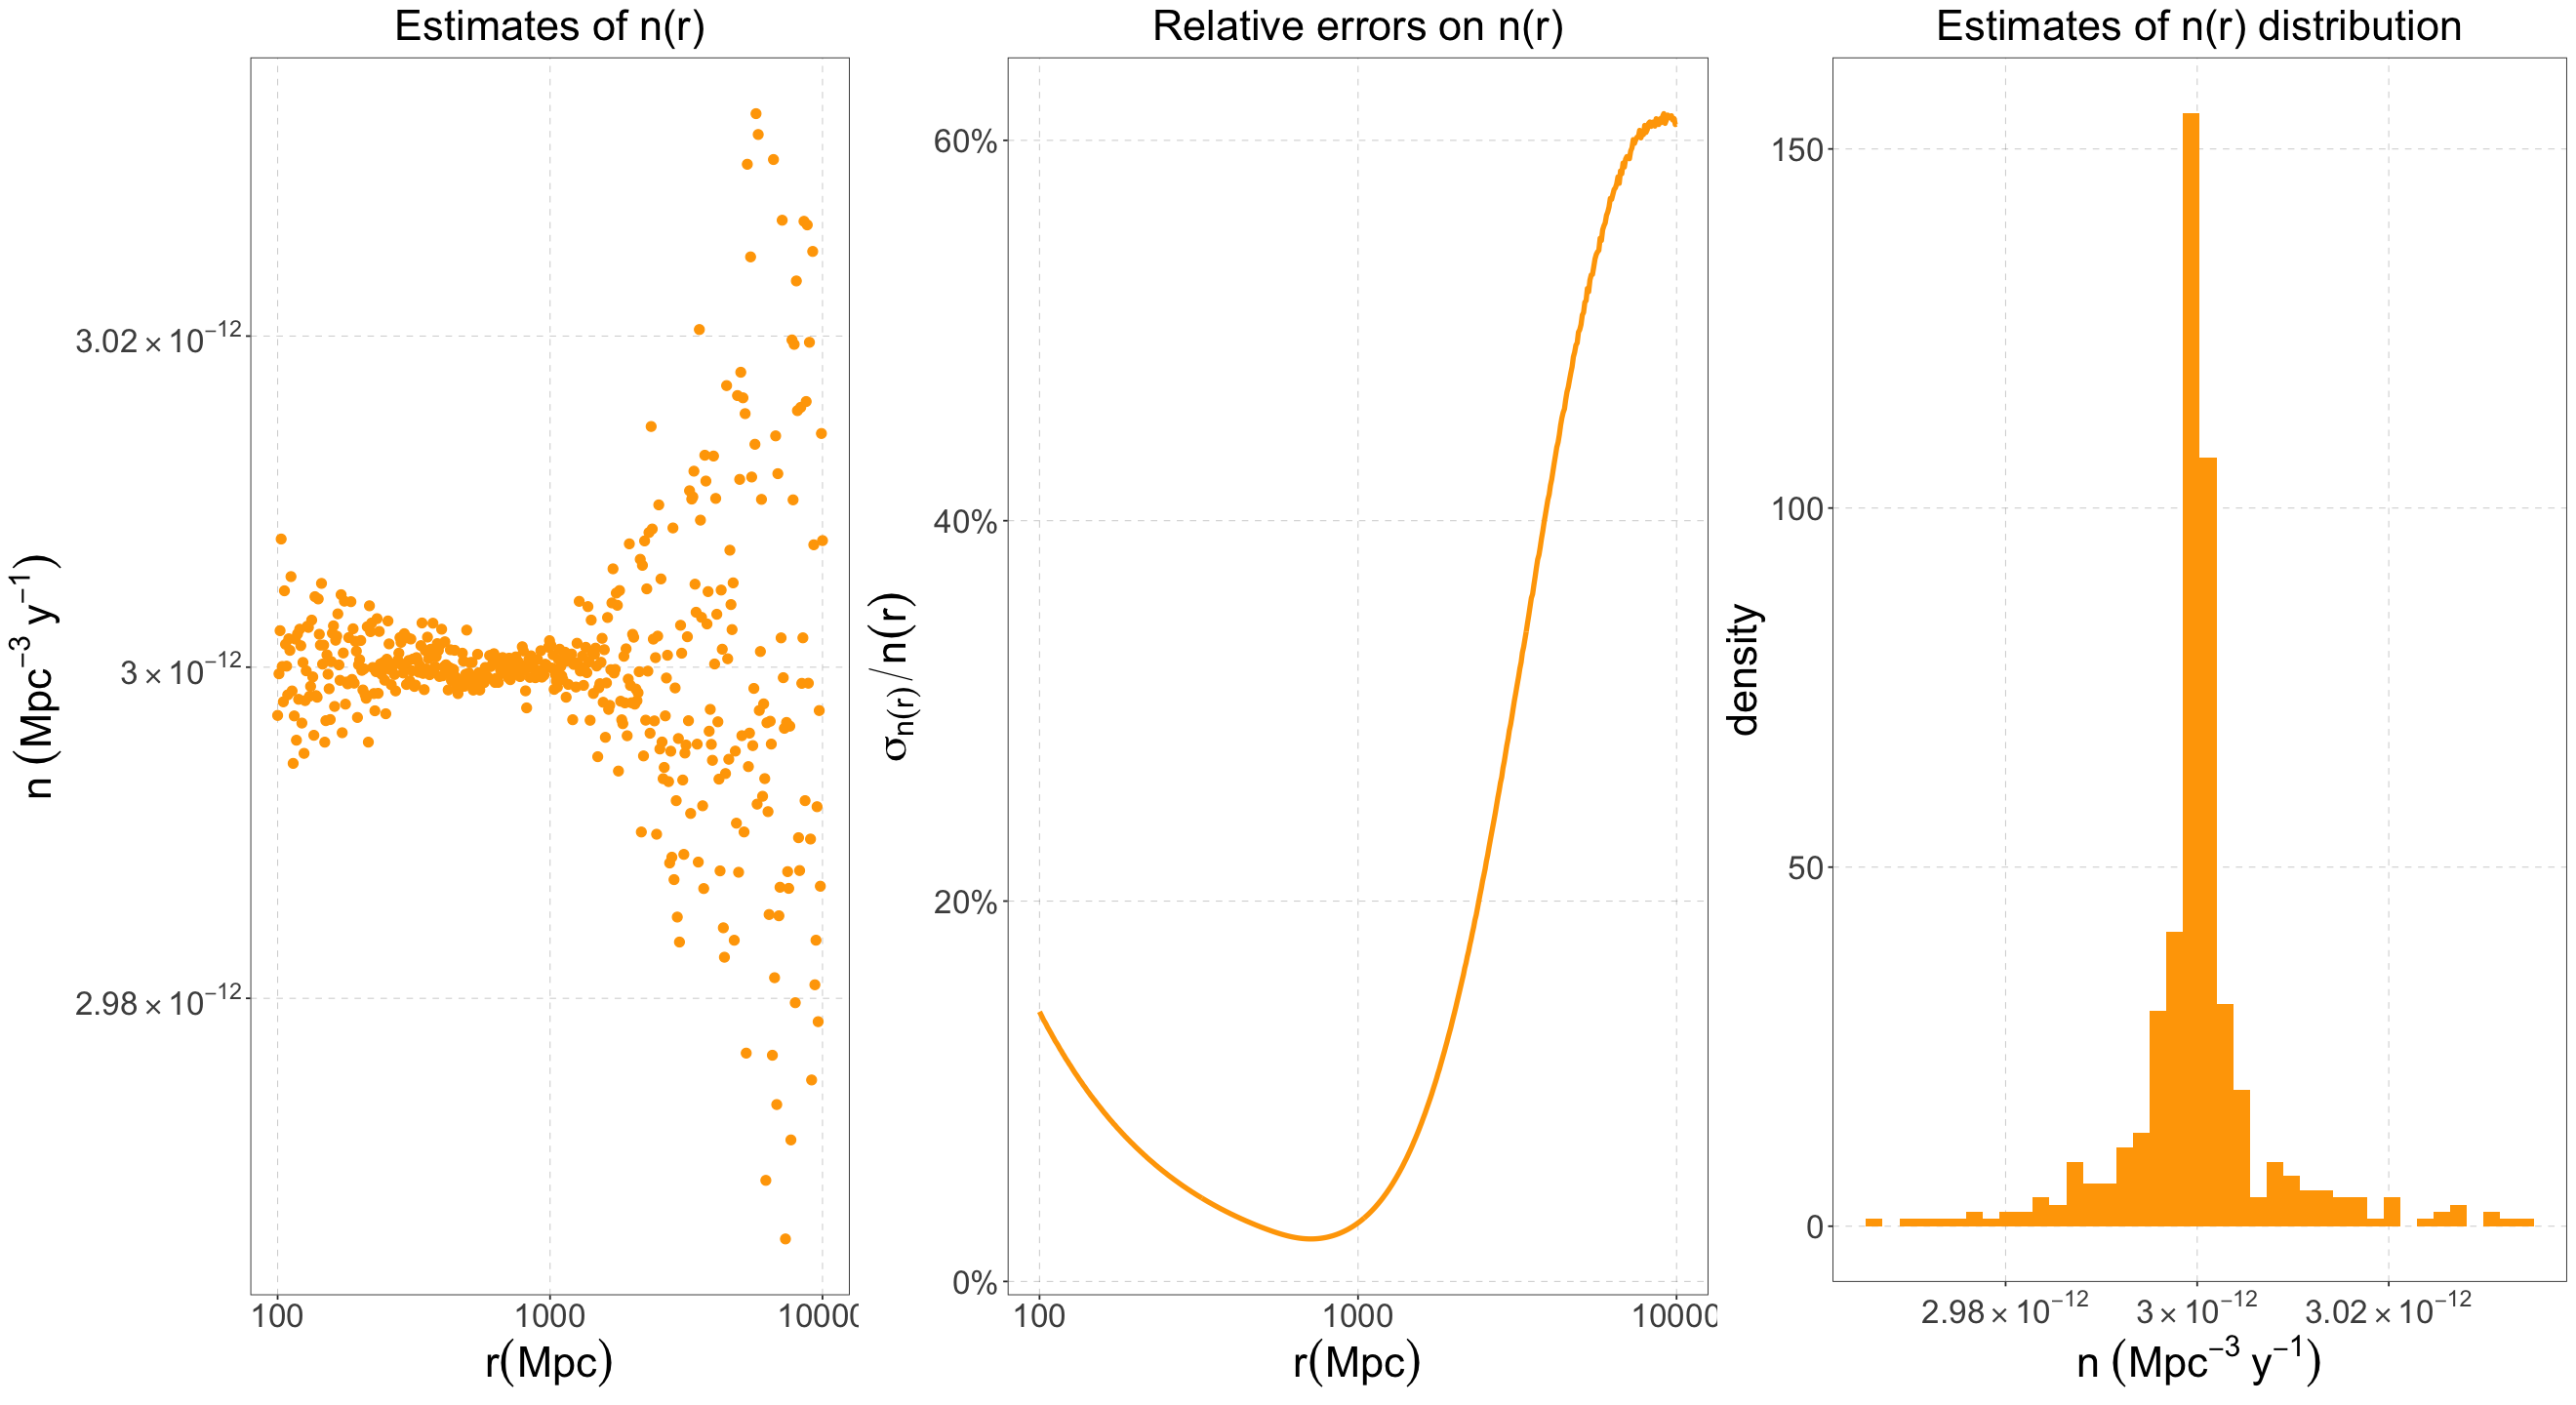

In [ ]:
plot1 <- ggplot() +
  geom_point(
    aes(x = r_hist, y = n_uni),
    color = color_palette[5], size = 2.5) +
  labs(
    x = expression(r(Mpc)),
    y = expression(n~(Mpc^{-3}~y^{-1})),
    title = 'Estimates of n(r)') +
  scale_x_log10() +
  scale_y_continuous(label=scientific_10) +
  theme_bw() +
theme( 
    plot.title = element_text(size = 26, hjust = 0.5),
    axis.title = element_text(size = 26),
    axis.text  = element_text(size = 20),
    legend.position = "top",
    legend.text  = element_text(size = 18),
    panel.grid.major.y = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.major.x = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    legend.background = element_rect( 
                            fill = "white",
                            linewidth = 0.5, 
                            linetype = "solid", 
                            colour = "white" 
                            ) 
)

plot2 <- ggplot() +
  geom_line(aes(x = r_hist, y = n_uni_err * 100 / n_uni), color = color_palette[5], linewidth = 1.5) +
  labs(
    x = expression(r(Mpc)),
    y = expression(sigma[n(r)]/n(r)),
    title = "Relative errors on n(r)") +
  scale_x_log10() +
  scale_y_continuous(labels = scales::percent) +
  theme_bw() +
theme( 
    plot.title = element_text(size = 26, hjust = 0.5),
    axis.title = element_text(size = 26),
    axis.text  = element_text(size = 20),
    legend.position = "top",
    legend.text  = element_text(size = 18),
    panel.grid.major.y = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.major.x = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    legend.background = element_rect( 
                            fill = "white",
                            linewidth = 0.5, 
                            linetype = "solid", 
                            colour = "white" 
                            ) 
)

plot3 <- ggplot() +
  geom_histogram(aes(x = n_uni), bins = 40, fill = color_palette[5]) +
  labs(
    title =  "Estimates of n(r) distribution",
    x = expression(n~(Mpc^{-3}~y^{-1})),
    y = 'density') +
    scale_x_continuous(label=scientific_10) +
  theme_bw() +
theme( 
    plot.title = element_text(size = 26, hjust = 0.5),
    axis.title = element_text(size = 26),
    axis.text  = element_text(size = 20),
    legend.position = "top",
    legend.text  = element_text(size = 18),
    panel.grid.major.y = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.major.x = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    legend.background = element_rect( 
                            fill = "white",
                            linewidth = 0.5, 
                            linetype = "solid", 
                            colour = "white" 
                            ) 
)

std_width  <- 22
std_height <- 12
options(repr.plot.width = std_width, repr.plot.height = std_height)

grid_arranged <- grid.arrange(plot1, plot2, plot3, ncol = 3)

Case of n = n (r)

In [ ]:
# inferring n from simulations with n = n(r)

set.seed(290623)

# Gamma posterior parameters

# shape
alpha_gamma_post_r <- c()

for(i in seq(1, length(lambda_simul_r), length.out = dimension_n)){
    alpha_gamma_post_r <- c( alpha_gamma_post_r, 1 + sum(rpois(sample_dim, lambda_simul_r[i])))
}

# rate
lambda_gamma_post_r <- sample_dim

In [ ]:
# finding distributions means and variances
N_means_r <- c()
N_var_r <- c()

for(i in alpha_gamma_post_r) {
    N_means_r <- c(N_means_r, i/lambda_gamma_post_r )
    N_var_r <- c(N_var_r, i/(lambda_gamma_post_r^2))
}

In [ ]:
# finding n

n_r_post <- N_means_r/(e_hist * 4 * pi * r_hist^2 * DeltaR * T)

n_r_err <- sqrt(N_var_r)/(e_hist * 4 * pi * r_hist^2 * DeltaR * T)

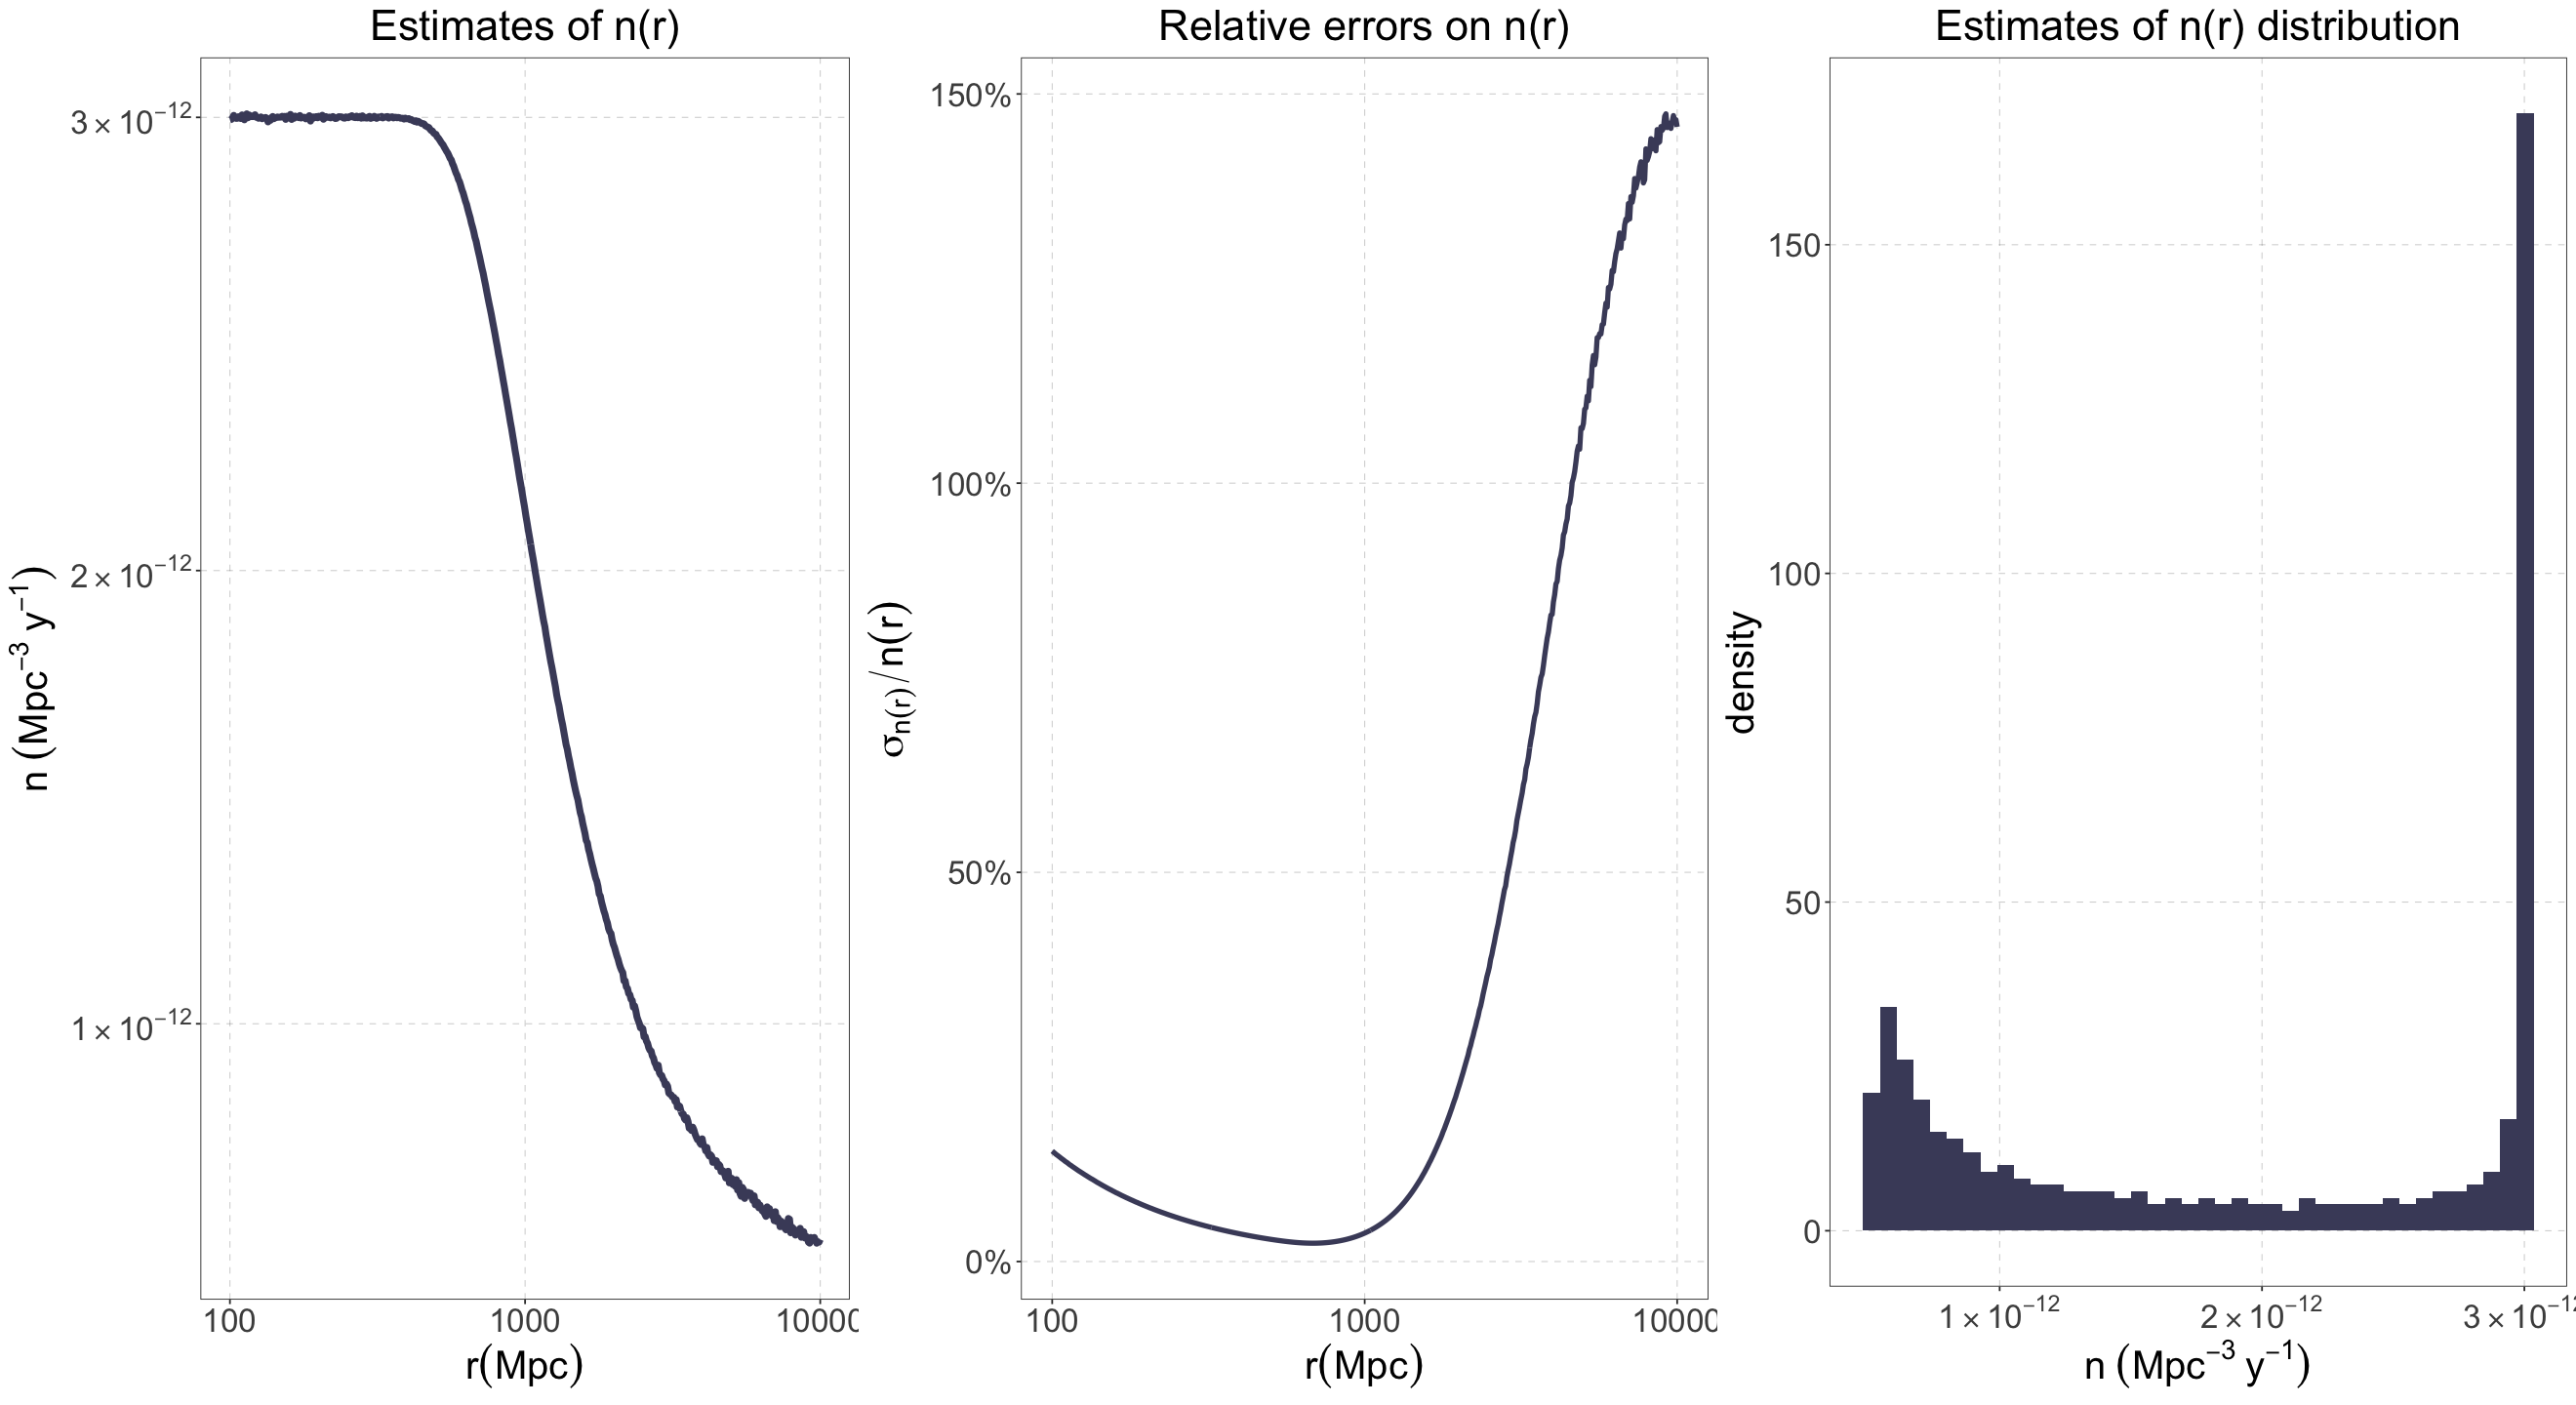

In [ ]:
plot1 <- ggplot() +
  geom_line(
    aes(x = r_hist, y = n_r_post),
    color = "#494b69", linewidth = 2) +
  labs(
    x = expression(r(Mpc)),
    y = expression(n~(Mpc^{-3}~y^{-1})),
    title = 'Estimates of n(r)') +
  scale_x_log10() +
  scale_y_continuous(label=scientific_10) +
  theme_bw() +
theme( 
    plot.title = element_text(size = 26, hjust = 0.5),
    axis.title = element_text(size = 24),
    axis.text  = element_text(size = 20),
    legend.position = "top",
    legend.text  = element_text(size = 18),
    panel.grid.major.y = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.major.x = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    legend.background = element_rect( 
                            fill = "white",
                            linewidth = 0.5, 
                            linetype = "solid", 
                            colour = "white" 
                            ) 
)

plot2 <- ggplot() +
  geom_line(aes(x = r_hist, y = n_r_err * 100 / n_r_post), color = "#494b69", linewidth = 1.5) +
  labs(
    x = expression(r(Mpc)),
    y = expression(sigma[n(r)]/n(r)),
    title = "Relative errors on n(r)") +
  scale_x_log10() +
  scale_y_continuous(labels = scales::percent) +
  theme_bw() +
theme( 
    plot.title = element_text(size = 26, hjust = 0.5),
    axis.title = element_text(size = 24),
    axis.text  = element_text(size = 20),
    legend.position = "top",
    legend.text  = element_text(size = 18),
    panel.grid.major.y = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.major.x = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    legend.background = element_rect( 
                            fill = "white",
                            linewidth = 0.5, 
                            linetype = "solid", 
                            colour = "white" 
                            ) 
)

plot3 <- ggplot() +
  geom_histogram(aes(x = n_r_post), bins = 40, fill = "#494b69") +
  labs(
    title =  "Estimates of n(r) distribution",
    x = expression(n~(Mpc^{-3}~y^{-1})),
    y = 'density') +
    scale_x_continuous(label=scientific_10) +
  theme_bw() +
theme( 
    plot.title = element_text(size = 26, hjust = 0.5),
    axis.title = element_text(size = 24),
    axis.text  = element_text(size = 20),
    legend.position = "top",
    legend.text  = element_text(size = 18),
    panel.grid.major.y = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.major.x = element_line( 
                            color = alpha("black",0.2),
                            linewidth = 0.3,
                            linetype = 2 
                            ),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    legend.background = element_rect( 
                            fill = "white",
                            linewidth = 0.5, 
                            linetype = "solid", 
                            colour = "white" 
                            ) 
)

grid_arranged <- grid.arrange(plot1, plot2, plot3, ncol = 3)

#### Inference on $n(r)$ using JAGS

In [ ]:
# we want to infer n(r), for example from r = 1000 Mpc
# we want to sample directly from the posterior for n(r)

set.seed(290623)

sample_dim_mcmc <- 1e3  # number of simulated data
r_sim <- 1e3 # Mpc
lambda_simul_r <- 4 * pi * r_sim^2 * DeltaR * n_r[r == r_sim] * T * epsilon_r[r == r_sim] 

# simulated data (considered as real)
data <- NULL
data$N <- rpois(sample_dim_mcmc, lambda_simul_r)
data$const <- 4 * pi * r_sim^2 * DeltaR * T * epsilon_r[r == r_sim]

In [ ]:
jm <- jags.model("inference.bug", data)

update(jm, 1000)
chain <- coda.samples(jm, c('n_r'), n.iter = 5e4, thin = 10)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1000
   Unobserved stochastic nodes: 1
   Total graph size: 1005

Initializing model



In [ ]:
summary(chain)


Iterations = 2010:52000
Thinning interval = 10 
Number of chains = 1 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     2.119e-12      7.679e-15      1.086e-16      0.000e+00 

2. Quantiles for each variable:

     2.5%       25%       50%       75%     97.5% 
2.104e-12 2.114e-12 2.119e-12 2.124e-12 2.134e-12 


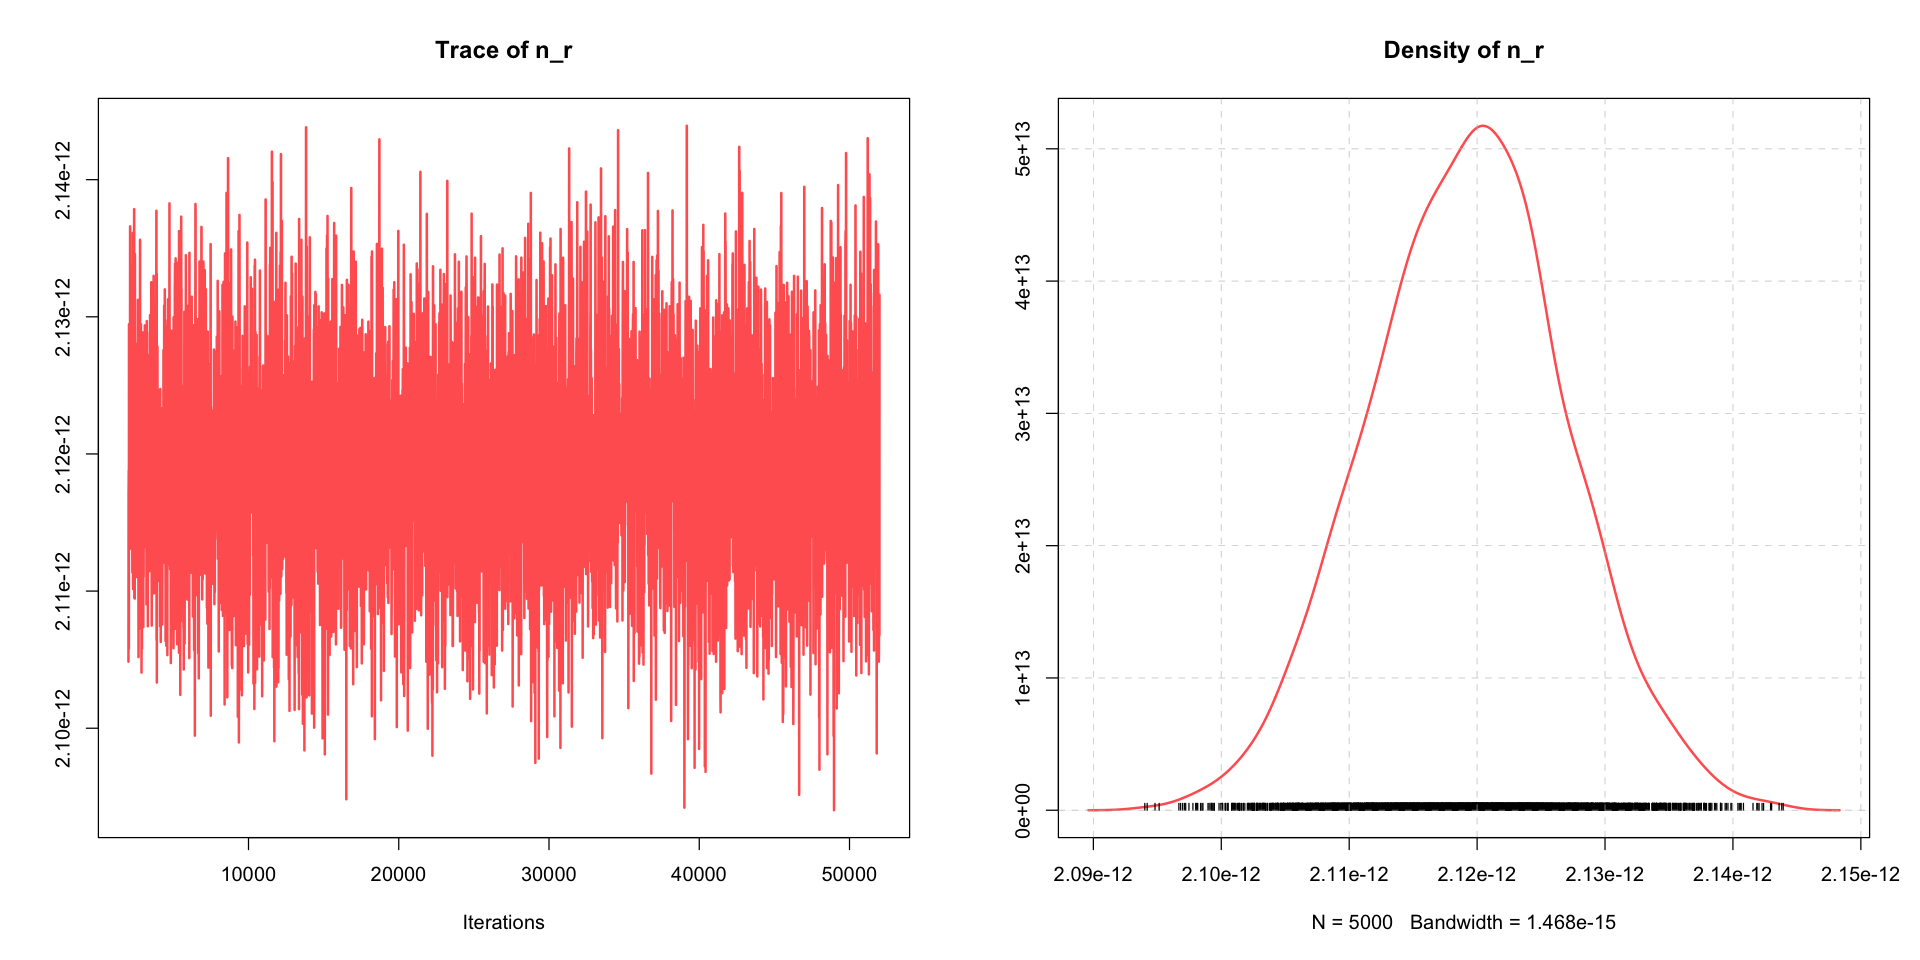

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 8)
par(mfrow = c(1,2), oma = c(0, 0, 0, 0))

plot(chain, col = '#ff6361', lwd = 2)
grid(nx = NULL, ny = NULL,
	lty = 2, lwd = 0.5,
	col = 'gray')

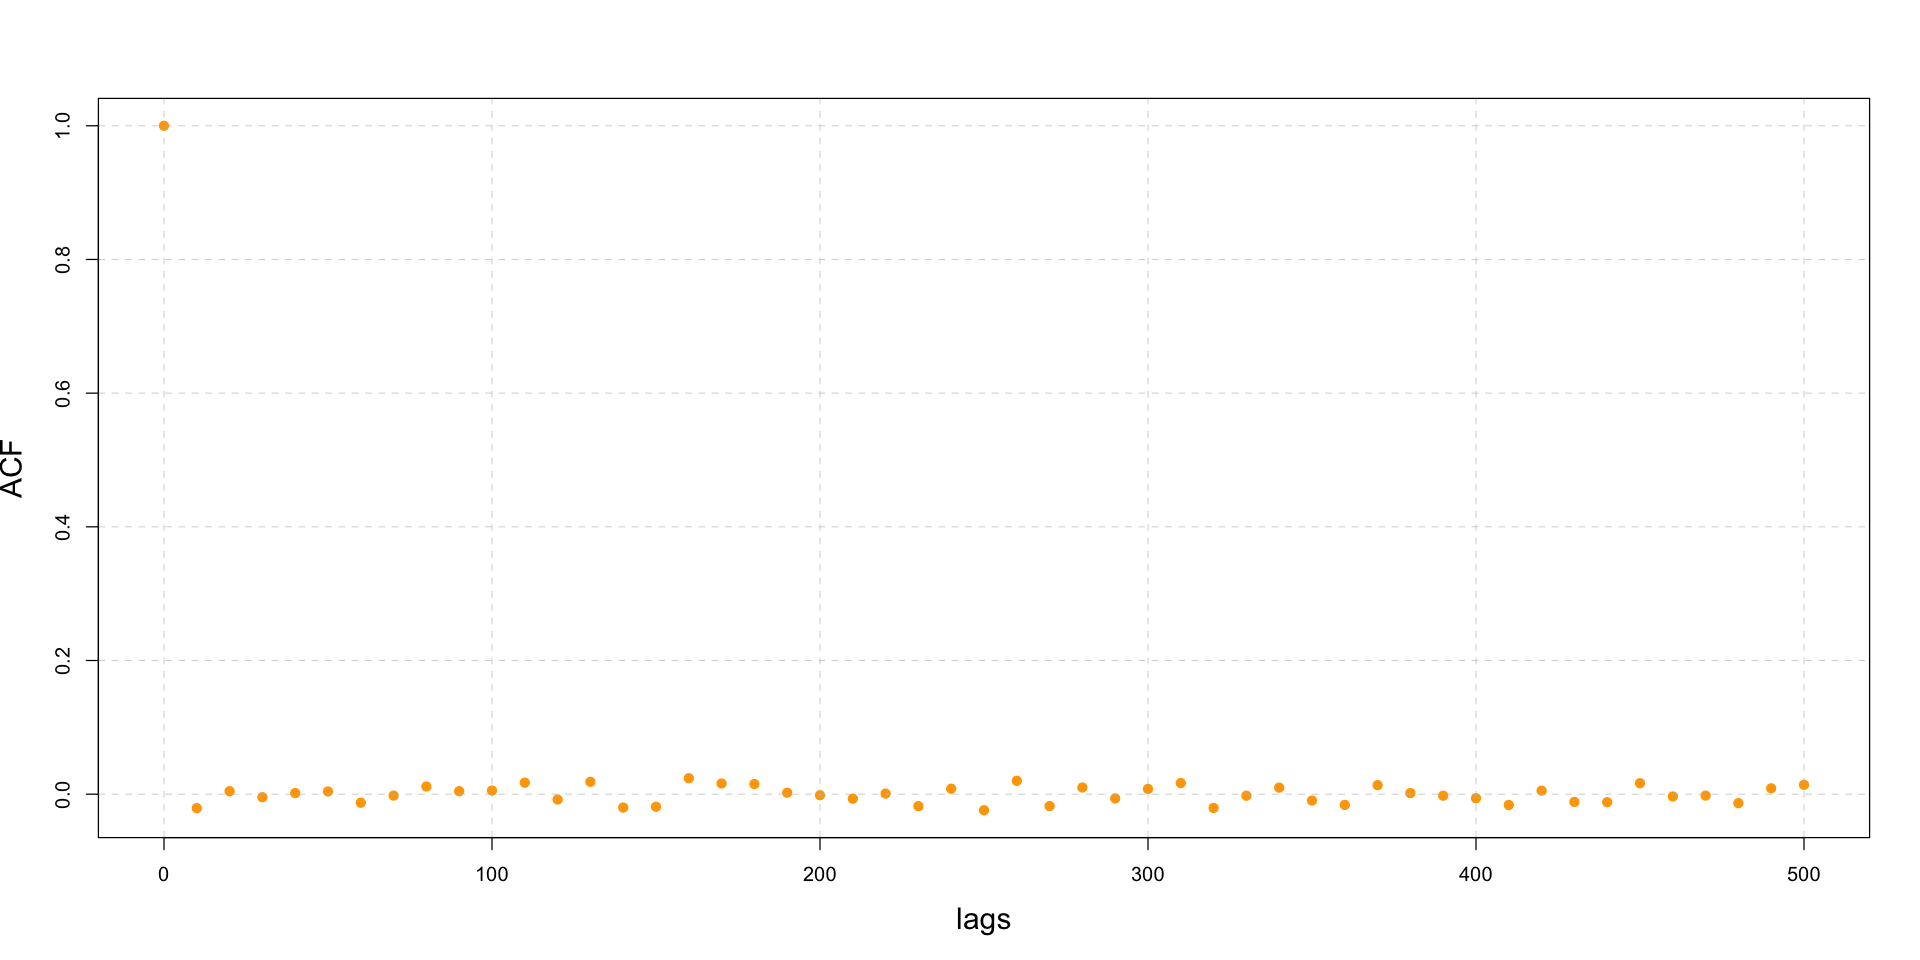

In [ ]:
# chain autocorrelation function

coda_chain <- as.mcmc(chain)

lags <- seq(0, 500, 10)
ACF <- autocorr(coda_chain, lags = lags)
eff_size <- effectiveSize(coda_chain)

plot(lags, ACF,
    pch = 19, col = '#ffa600',
    cex.lab = 1.5)
grid(nx = NULL, ny = NULL,
	lty = 2, lwd = 0.5,
	col = 'gray')

### Hypothesis testing on the two populations

We now want to perform an hypothesis testing with Bayesian approach: given the two populations (uniform $n$ and sigmoid $n(r)$), if we find $N_{obs} = 195$ sources at a distance of 600 Mpc, are we able to determine with a significance $\alpha = 5\%$ if this data follows one of the two populations?

In [ ]:
N_test <- 195
r_test <- 600
epsilon_600 <- pnorm(1e5/r_test, h0, w)
n_600 <- n * pnorm(1e5/r_test, h0_new, w_new)

lambda_1_test <- 4 * pi * r_test^2 * DeltaR * T * n * epsilon_600
lambda_2_test <- 4 * pi * r_test^2 * DeltaR * T * n_600 * epsilon_600

data1 <- rpois(sample_dim, lambda_1_test)
data2 <- rpois(sample_dim, lambda_2_test)

Nobs <- seq(110,240,1)

Nobsmin1 <- qnorm(0.025, mean = lambda_1_test, sd = sqrt(lambda_1_test))
Nobsmax1 <- qnorm(1-0.025, mean = lambda_1_test, sd = sqrt(lambda_1_test))
Nobsmin2 <- qnorm(0.025, mean = lambda_2_test, sd = sqrt(lambda_2_test))
Nobsmax2 <- qnorm(1-0.025, mean = lambda_2_test, sd = sqrt(lambda_2_test))

normapprox1 <- dnorm(Nobs, mean = lambda_1_test, sd = sqrt(lambda_1_test))
normapprox2 <- dnorm(Nobs, mean = lambda_2_test, sd = sqrt(lambda_2_test))

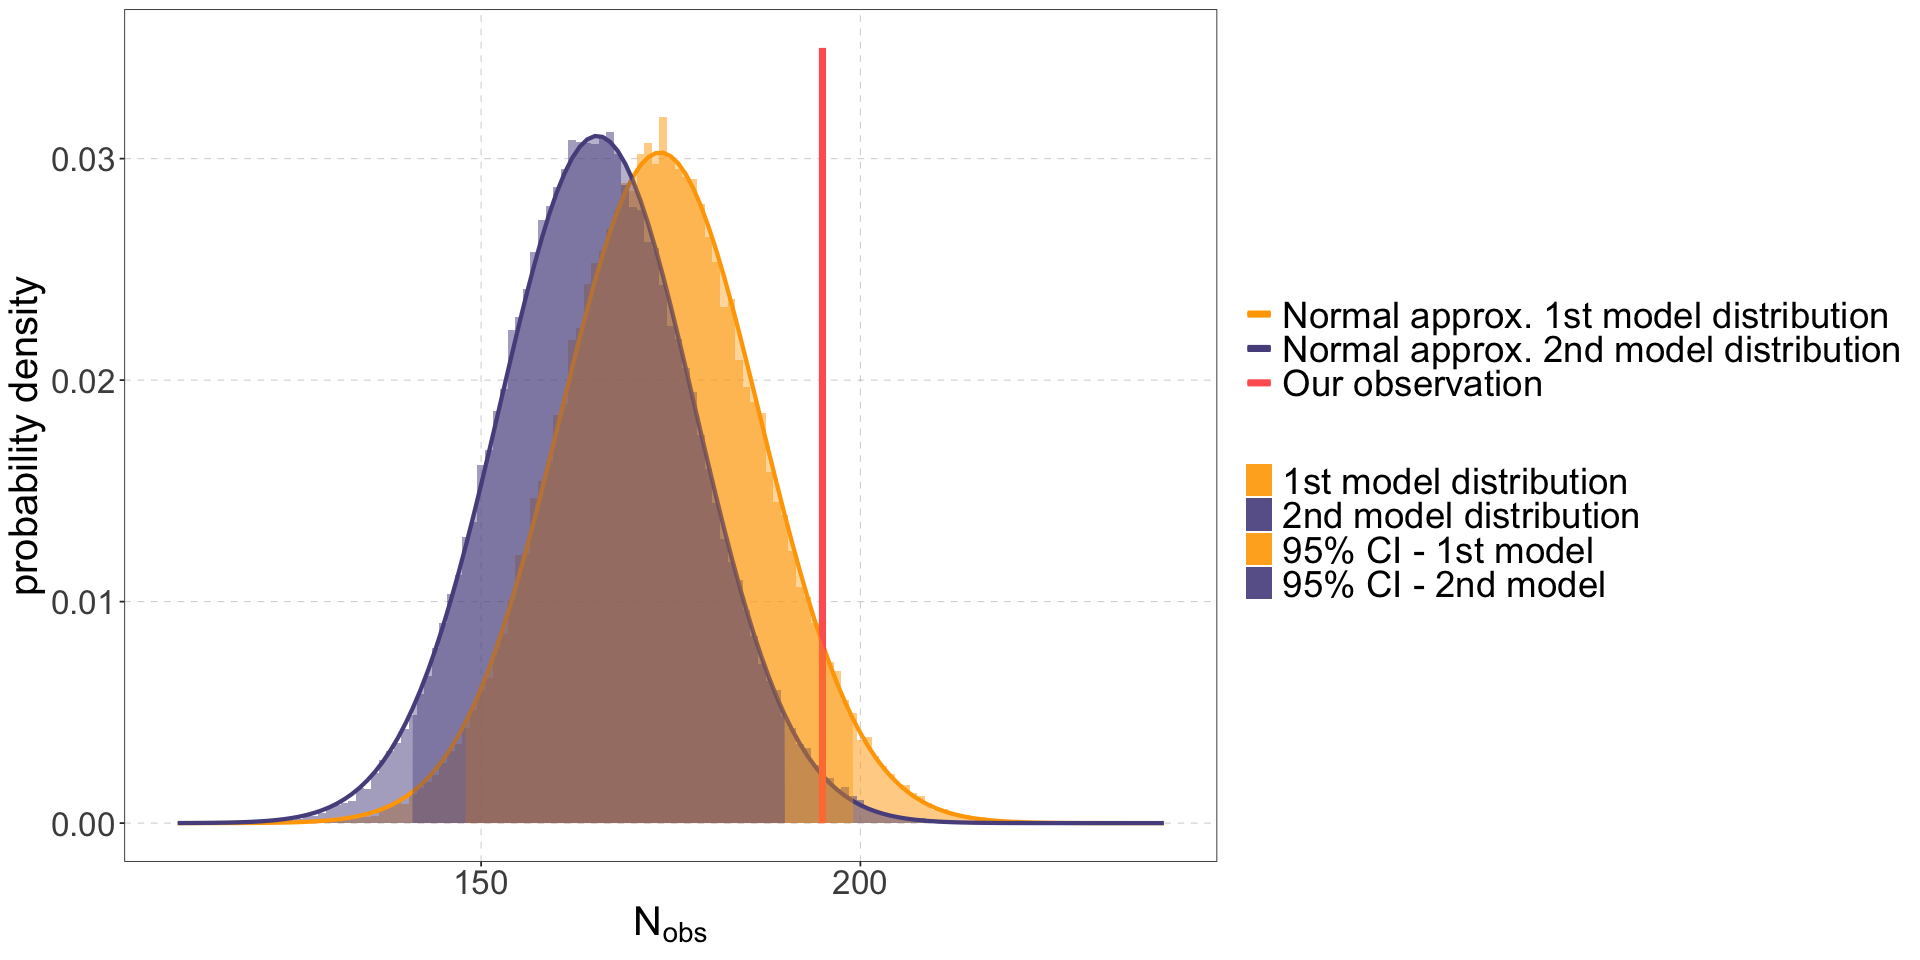

In [ ]:
plotHT <- ggplot() +
            geom_histogram(
                aes(
                    x = data1,
                    y = after_stat(density),
                    fill = "1st model distribution"
                ),
                binwidth = 1,
                alpha = 0.5
            ) +
            geom_histogram(
                aes(
                    x = data2,
                    y = after_stat(density),
                    fill = "2nd model distribution"
                ),
                binwidth = 1,
                alpha = 0.5
            ) +
            geom_line(
                aes(
                    x = Nobs,
                    y = dnorm(Nobs, mean = lambda_1_test, sd = sqrt(lambda_1_test)),
                    color = "Normal approx. 1st model distribution"
                ),
                linewidth = 1.2
            ) +
            geom_line(
                aes(
                    x = Nobs,
                    y = dnorm(Nobs, mean = lambda_2_test, sd = sqrt(lambda_2_test)),
                    color = "Normal approx. 2nd model distribution"
                ),
                linewidth = 1.2
            ) +
            geom_segment(
                aes(
                    x = N_test,
                    y = 0,
                    xend = N_test,
                    yend = 0.035,
                    color = "Our observation"
                ),
                linewidth = 2
            ) +
            geom_area(
                aes(
                    x = Nobs[Nobs > Nobsmin1 & Nobs < Nobsmax1],
                    y = normapprox1[Nobs > Nobsmin1 & Nobs < Nobsmax1],
                    fill = "95% CI - 1st model"
                    ),
                alpha = 0.4
            ) +
            geom_area(
                aes(
                    x = Nobs[Nobs > Nobsmin2 & Nobs < Nobsmax2],
                    y = normapprox2[Nobs > Nobsmin2 & Nobs < Nobsmax2],
                    fill = "95% CI - 2nd model"
                    ),
                alpha = 0.4
            ) +
            scale_fill_manual(
                name = "",
                values = c(
                    "1st model distribution" = color_palette[5],
                    "95% CI - 1st model" = color_palette[5],
                    "2nd model distribution" = color_palette[2],
                    "95% CI - 2nd model" = color_palette[2]
                )
            ) +
            scale_color_manual(
                name = "",
                values = c(
                    "Our observation" = color_palette[4],
                    "Normal approx. 1st model distribution" = color_palette[5],
                    "Normal approx. 2nd model distribution" = color_palette[2]
                )
            ) +
            labs(
                x = expression(N[obs]),
                y = "probability density"
            ) +
            scale_x_continuous(n.breaks = 5) +
            theme_bw() +
            theme( 
                plot.title = element_text(size = 26, hjust = 0.5),
                axis.title = element_text(size = 24),
                axis.text  = element_text(size = 20),
                legend.position = "right",
                legend.text  = element_text(size = 22),
                panel.grid.major.y = element_line( 
                                        color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 
                                        ),
                panel.grid.major.x = element_line( 
                                        color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 
                                        ),
                panel.grid.minor = element_blank(),
                panel.background = element_blank(),
                legend.background = element_rect( 
                                        fill = "white",
                                        linewidth = 0.5, 
                                        linetype = "solid", 
                                        colour = "white" 
                                        ) 
            )

plotHT

### 5. Searching for T min such that I can distinguish the two models

In [ ]:
# distances at which we do the analysis by varying T (Mpc)
r_T <- c(360, 380, 400, 420, 440, 460)
deltaR_time <- 10^(-3)*r_T

# time (year)
time <- seq(0.05, 10, length.out = 12)

# Poisson distribution rate as a function of r and time

# case n = const
lambda_time_nconst <- c()

for(i in 1:length(r_T)){
    lambda_time_nconst <- cbind( lambda_time_nconst, 4 * pi * r_T[i]^2 * deltaR_time[i] * time*3*10^7 * pnorm(1e5/r_T[i], h0, w) * n  )
}

# case n = n(r)
lambda_time_nr <- c()

for(i in 1:length(r_T)){
    lambda_time_nr <- cbind( lambda_time_nr, 4 * pi * r_T[i]^2 * deltaR_time[i] * time*3*10^7 * pnorm(1e5/r_T[i], h0_new, w_new) * n * pnorm(1e5/r_T[i], h0, w)  )
}

# inference on n

# n = const
alpha_nconst <- c()
for(i in 1:length(r_T)){

    b <- c()

    for(j in 1:length(time)){
        b <- c(b, 1 + sum(rpois(sample_dim, lambda_time_nconst[j,i])))
    }

    alpha_nconst <- cbind(alpha_nconst, b)
}

N_means_nconst <- c()
N_vars_nconst <- c()

for(i in 1:length(r_T)){

    a <- c()
    b <- c()

    for(j in 1:length(time)){
        a <- c(a, alpha_nconst[j,i]/sample_dim )
        b <- c(b, alpha_nconst[j,i]/(sample_dim^2) )
    }

    N_means_nconst <- cbind(N_means_nconst, a)
    N_vars_nconst <- cbind(N_vars_nconst, b)
}

n_nconst <- c()
n_err_nconst <- c()

for(i in 1:length(r_T)){

    a <- c()
    b <- c()

    for(j in 1:length(time)){
        a <- c(a, N_means_nconst[j,i]/(4 * pi * r_T[i]^2 * deltaR_time[i] * time[j]*3*10^7 * pnorm(1e5/r_T[i], h0, w) ))
        b <- c(b, sqrt(N_vars_nconst[j,i])/(4 * pi * r_T[i]^2 * deltaR_time[i] * time[j]*3*10^7 * pnorm(1e5/r_T[i], h0, w)) )
    }

    n_nconst <- cbind(n_nconst, a)
    n_err_nconst <- cbind(n_err_nconst, b)
}


# n = n(r)
alpha_nr <- c()
for(i in 1:length(r_T)){

    b <- c()

    for(j in 1:length(time)){
        b <- c(b, 1 + sum(rpois(sample_dim, lambda_time_nr[j,i])))
    }

    alpha_nr <- cbind(alpha_nr, b)
}

rownames(alpha_nr) <- paste( round(time, 2), 'y' )
colnames(alpha_nr) <- paste( r_T, 'Mpc - n = n(r)' )

N_means_nr <- c()
N_vars_nr <- c()

for(i in 1:length(r_T)){

    a <- c()
    b <- c()

    for(j in 1:length(time)){
        a <- c(a, alpha_nr[j,i]/sample_dim )
        b <- c(b, alpha_nr[j,i]/(sample_dim^2) )
    }

    N_means_nr <- cbind(N_means_nr, a)
    N_vars_nr <- cbind(N_vars_nr, b)
}

n_nr <- c()
n_err_nr <- c()

for(i in 1:length(r_T)){

    a <- c()
    b <- c()

    for(j in 1:length(time)){
        a <- c(a, N_means_nr[j,i]/(4 * pi * r_T[i]^2 * deltaR_time[i] * time[j]*3*10^7 * pnorm(1e5/r_T[i], h0, w) ))
        b <- c(b, sqrt(N_vars_nr[j,i])/(4 * pi * r_T[i]^2 * deltaR_time[i] * time[j]*3*10^7 * pnorm(1e5/r_T[i], h0, w)) )
    }



    n_nr <- cbind(n_nr, a)
    n_err_nr <- cbind(n_err_nr, b)
}

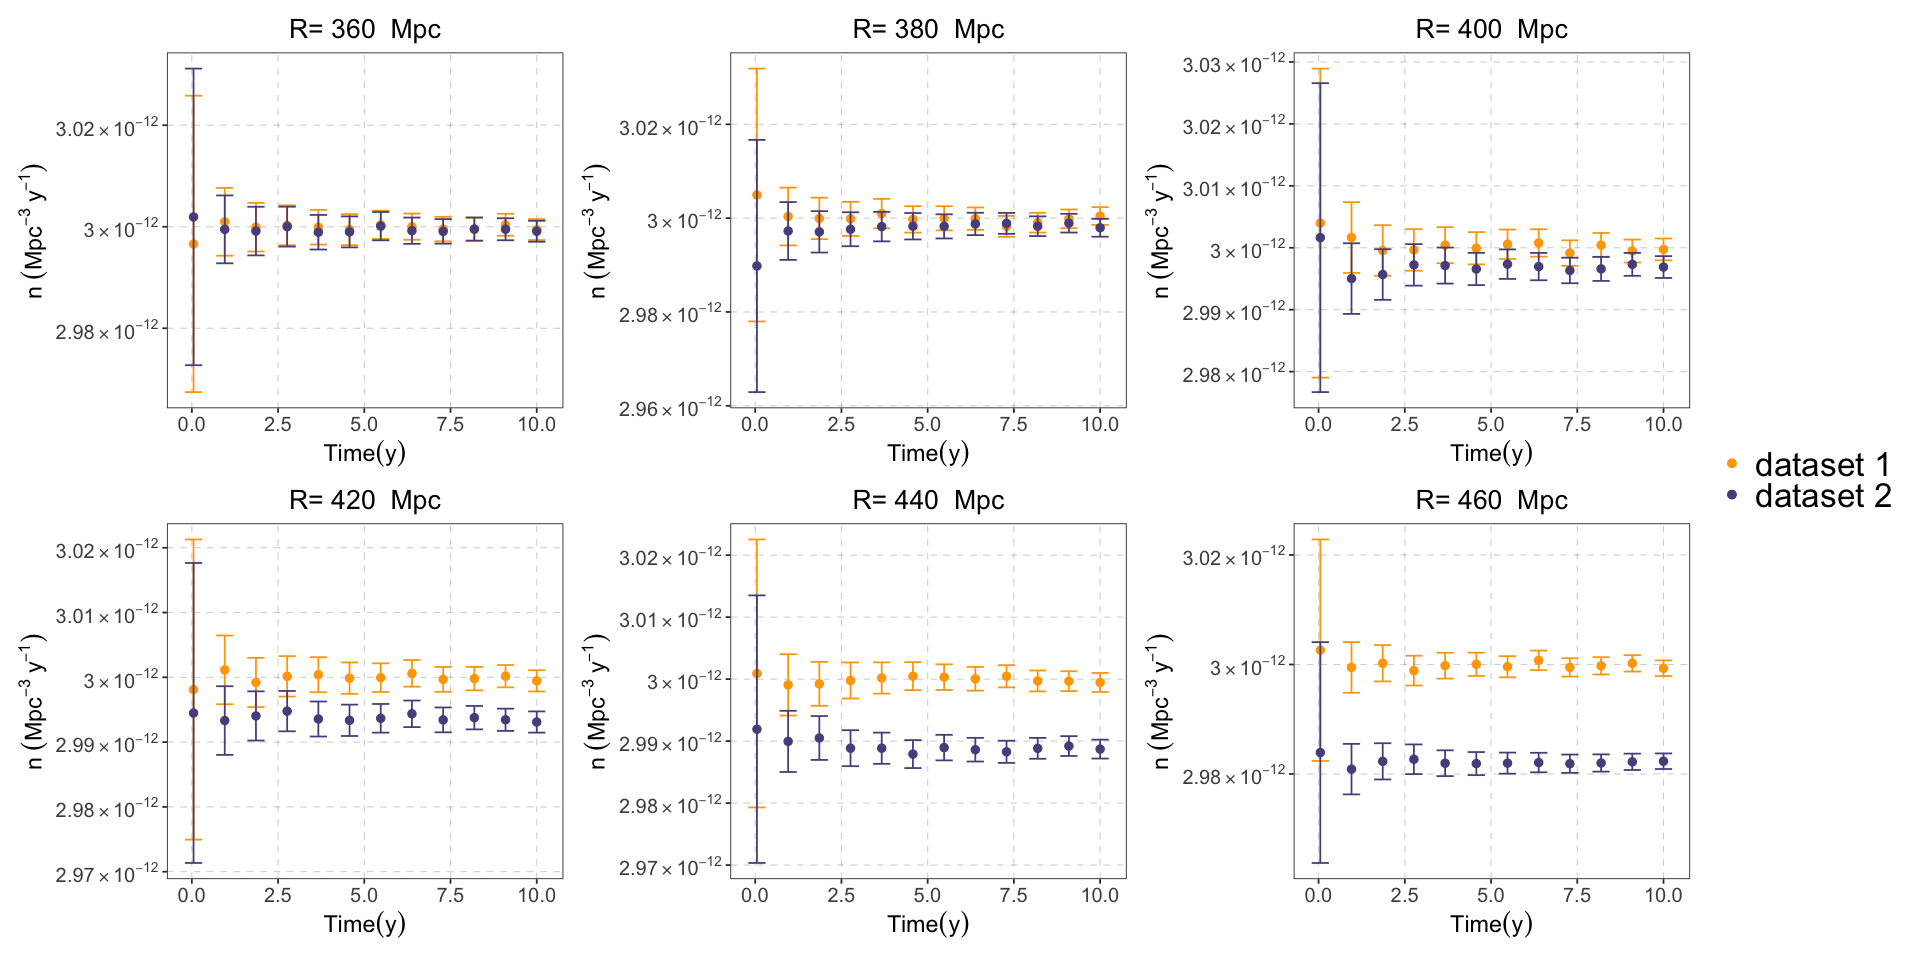

In [ ]:
# error bars
sigma <- 5

plot_list <- lapply(seq(1, length(r_T)), function(i) {
  p1 <- ggplot() +
    geom_point(
      aes(
        x = time,
        y = n_nconst[,i],
        color = "dataset 1"
      ),
      size = 2
    ) +
    geom_errorbar(
      aes(
        ymin = n_nconst[, i] - sigma * n_err_nconst[, i],
        ymax = n_nconst[, i] + sigma * n_err_nconst[, i],
        x = time,
        y = n_nconst[,i]
        ),
      width = 0.5, 
      color = color_palette[5]
    ) +
    geom_point(
      aes(
        x = time,
        y = n_nr[,i],
        color = "dataset 2"
      ),
      size = 2
    ) +
    geom_errorbar(
      aes(
        x = time,
        y = n_nr[,i],
        ymin = n_nr[, i] - sigma * n_err_nr[, i],
        ymax = n_nr[, i] + sigma * n_err_nr[, i]
      ),
      width = 0.5, 
      color = color_palette[2]
    ) +
    scale_y_continuous(label=scientific_10) +
    labs(
      title = paste("R=", r_T[i], " Mpc"),
      x = expression(Time(y)),
      y = expression(n~(Mpc^{-3}~y^{-1}))
    ) +
    scale_color_manual(
      name = "",
      values = c(
        "dataset 1" = color_palette[5],
        "dataset 2" = color_palette[2]
      )
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 16, hjust = 0.5),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      legend.position = "right",
      legend.text  = element_text(size = 20),
      panel.grid.major.y = element_line(
        color = alpha("black", 0.2),
        linewidth = 0.3,
        linetype = 2
      ),
      panel.grid.major.x = element_line(
        color = alpha("black", 0.2),
        linewidth = 0.3,
        linetype = 2
      ),
      panel.grid.minor = element_blank(),
      panel.background = element_blank()
    )
  
  p1
})

combined_plots <- wrap_plots(plotlist = plot_list, nrow = 2, ncol = 3) +
  plot_layout(guides = "collect")

legend_plot <- get_legend(combined_plots)

final_plot <- combined_plots +
  plot_layout(
    nrow = 2,
    ncol = 3,
    widths = c(rep(0.85, 4), 0.15),
    heights = c(rep(0.95, 4), 0.05),
    guides = "collect"
  ) +
  plot_annotation(
    theme = theme(plot.title = element_text(hjust = 0))
  )


print(final_plot)

We can se that relative errors get smaller if the observation time increases. 
For example, at 420 Mpc we can see that for a reasonable observation time (~3y) we can distinguish the two population models. 

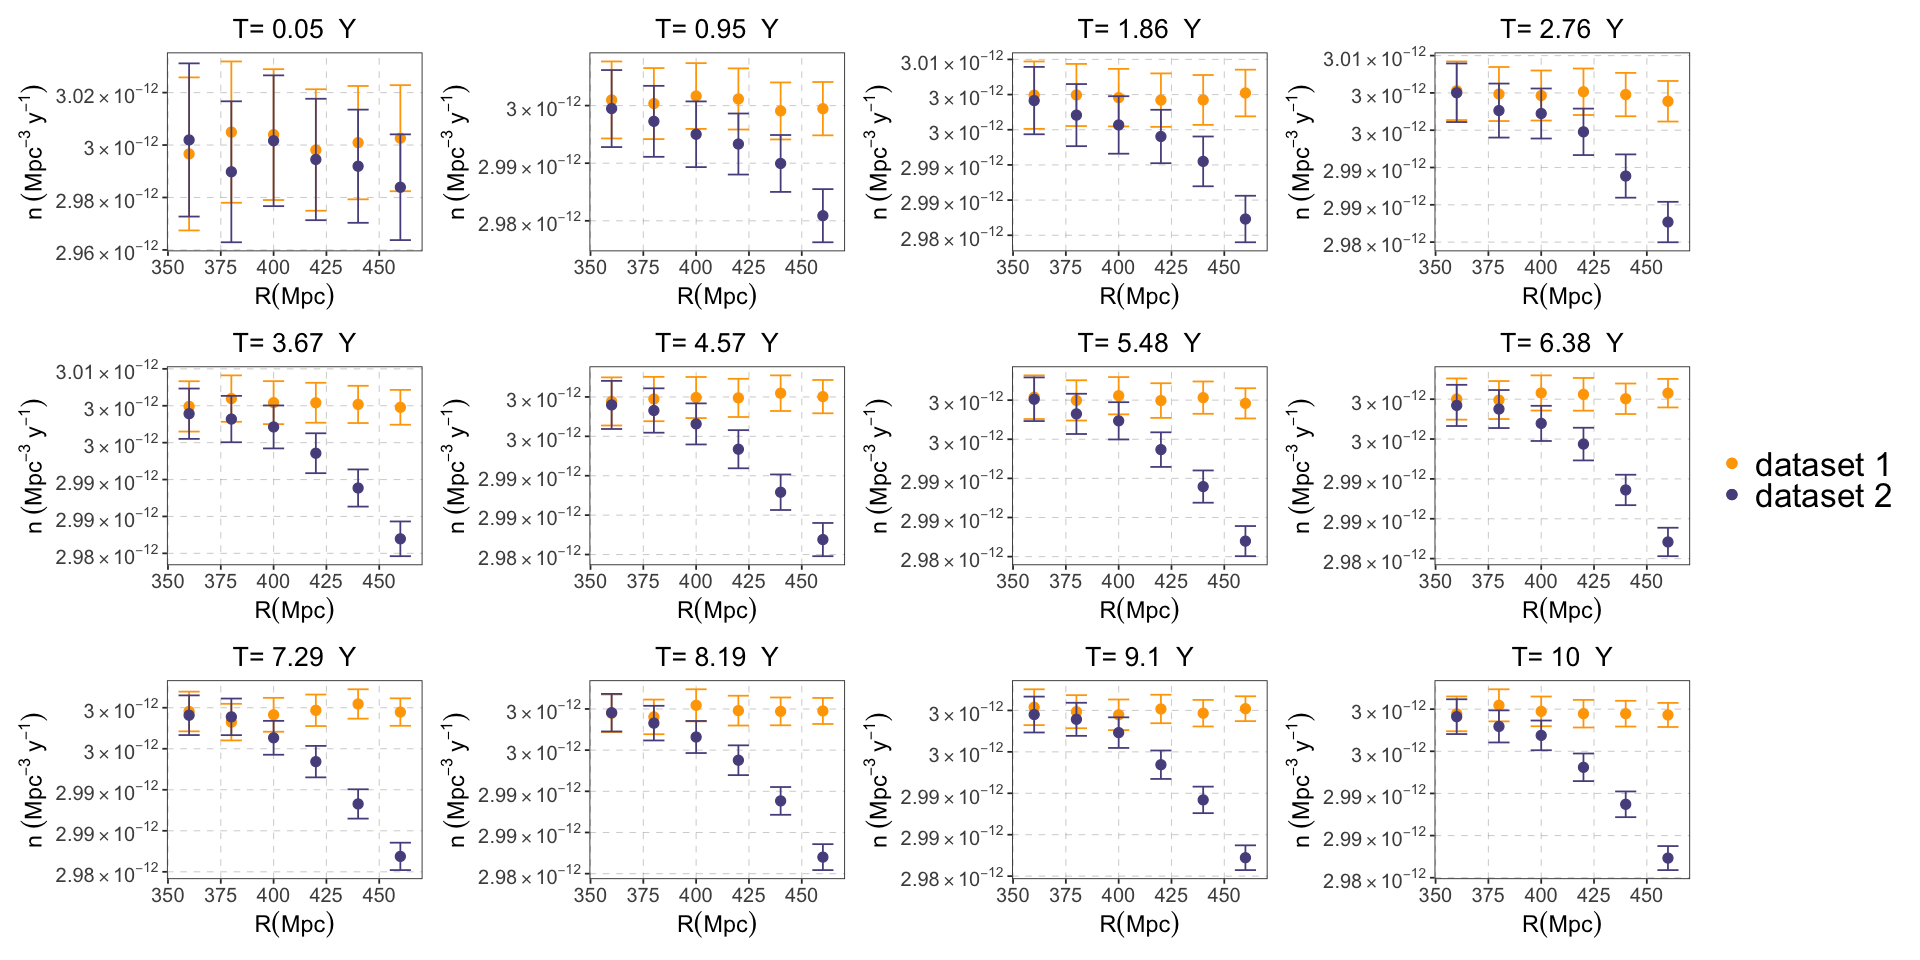

In [ ]:
# plot at fixed T

plot_list <- lapply(seq(1, length(time)), function(i) {
  p1 <- ggplot() +
    geom_point(
      aes(
        x = r_T,
        y = n_nconst[i,],
        color = "dataset 1"
      ),
      size = 2.5
    ) +
    geom_errorbar(
      aes(
        ymin = n_nconst[i,] - sigma * n_err_nconst[i,],
        ymax = n_nconst[i,] + sigma * n_err_nconst[i,],
        x = r_T,
        y = n_nconst[i,]
        ),
      width = 10, 
      color = color_palette[5]
    ) +
    geom_point(
      aes(
        x = r_T,
        y = n_nr[i,],
        color = "dataset 2"
      ),
      size = 2.5
    ) +
    geom_errorbar(
      aes(
        x = r_T,
        y = n_nr[i,],
        ymin = n_nr[i,] - sigma * n_err_nr[i,],
        ymax = n_nr[i,] + sigma * n_err_nr[i,]
      ),
      width = 10, 
      color = color_palette[2]
    ) +
    scale_y_continuous(label=scientific_10) +
    labs(
      title = paste("T=", round(time[i],2), " Y"),
      x = expression(R(Mpc)),
      y = expression(n~(Mpc^{-3}~y^{-1}))
    ) +
    scale_color_manual(
      name = "",
      values = c(
        "dataset 1" = color_palette[5],
        "dataset 2" = color_palette[2]
      )
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 16, hjust = 0.5),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      legend.position = "right",
      legend.text  = element_text(size = 20),
      panel.grid.major.y = element_line(
        color = alpha("black", 0.2),
        linewidth = 0.3,
        linetype = 2
      ),
      panel.grid.major.x = element_line(
        color = alpha("black", 0.2),
        linewidth = 0.3,
        linetype = 2
      ),
      panel.grid.minor = element_blank(),
      panel.background = element_blank()
    )
  
  p1
})

combined_plots <- wrap_plots(plotlist = plot_list, nrow = 3, ncol = 4) +
  plot_layout(guides = "collect")

legend_plot <- get_legend(combined_plots)

final_plot <- combined_plots +
  plot_layout(
    nrow = 3,
    ncol = 4,
    widths = c(rep(0.85, 4), 0.15),
    heights = c(rep(0.95, 4), 0.05),
    guides = "collect"
  ) +
  plot_annotation(
    theme = theme(plot.title = element_text(hjust = 0))
  )


print(final_plot)

As the observation time increases, the trend followed by the population density gets clearer.